In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import glob as gl
import thermocepstrum as tc
import pickle as pk


In [4]:
pwd

'/Users/davidetisi/Documents/PhD/Articolo_codiceAris/data_analysis_for_QEHeat'

In [5]:
def k_compute(current_list,dt_fs,Tmean,llvol,units='qepw'):
    '''
    Parameters
    ----------
    current_list : list
        list of currents to be analised for multicomponent, the zero element is the main current
    dt_fs : float 
        timestep in fs
    Tmean :float
        Mean Temperature in K
    llvol : float
        volume of the cell in A^3
    units : str
        system of units 
        
    Returns
    ---------
    jen : HeatCurrent 
        HeatCurrent object
    jjjen : dictionary
        dictionary : key =[1,2] the two corfactors
                    values = array with the fstar_analysis
    
    '''
    jen=tc.HeatCurrent(current_list,units=units,DT_FS=dt_fs,TEMPERATURE=Tmean,VOLUME=llvol,PSD_FILTER_W=0.1)
    jjjen ={}

    corrfactors = np.arange(1,3)
    for cor in corrfactors:
        TSKIP_LIST = [int(jen.Nyquist_f_THz/j) for j in range(2,80,2)]
        TSKIP_LIST = list(set(TSKIP_LIST))
        TSKIP_LIST.sort(reverse=True)
        TSKIP_LIST = np.array(TSKIP_LIST,dtype=np.int)
        print(TSKIP_LIST)
        #TSKIP_LIST = np.array([1,10,50,100,500,1000,5000,10000])
        #TSKIP_LIST = np.array([50000])
        jjjen[cor],ax,f = tc.current.fstar_analysis(jen, TSKIP_LIST, Kmin_corrfactor=cor)
    return jen, jjjen,TSKIP_LIST

In [6]:

def kappa_time(tr_ps,current_list,dt_fs,Tmean,llvol,units='qepw',fstar_THz=30.,Kmin_corrfactor=1):
    '''
    Parameters
    ----------
    tr_ps : list
        list of simulations lenghts in ps
    current_list : list
        list of currents to be analised for multicomponent, the zero element is the main current
    dt_fs : float 
        timestep in fs
    Tmean :float
        Mean Temperature in K
    llvol : float
        volume of the cell in A^3
    units : str
        system of units 
    fstar_THz : float
         Fstar in THz 
    Kmin_corrfactor : float
        corrfactor for AIC 
        
    Returns
    ---------
    jenTime : dictionary
        dictionary : key =[lenght_of_simulation] the lenght of analised time series 
        values = the HeatCurrent object
    jenTimef : dictionary
        dictionary : key =[lenght_of_simulation] the lenght of analised time series 
        values = the resampled HeatCurrent object
    kappas : numpy array
        numpy array containing the lenght of the simulation [0], values of kappa [1], the variance of kappa [2]
    
    '''
    jenTime ={}
    jenTimef ={}
    

    end_step = np.floor(tr_ps/(dt_fs*1e-3))

    print('end_step',end_step,end_step*dt_fs*1e-3)
    kappas = np.zeros((len(tr_ps),3))
    kappas[:,0] = tr_ps
    
    for i,end in enumerate(end_step):
        print(i,end)
        ltime = tr_ps[i]
        end = int(end)
        c_list =[]
        for jcurr in current_list:
            c_list.append(jcurr[0:end])
        
        jenTime[ltime] = tc.HeatCurrent(c_list,units=units,DT_FS=dt_fs,TEMPERATURE=Tmean,VOLUME=llvol,PSD_FILTER_W=0.1)
        jenTimef[ltime]    = jenTime[ltime].resample(fstar_THz=fstar_THz,plot=False,PSD_FILTER_W=0.1)
        jenTimef[ltime].cepstral_analysis(Kmin_corrfactor=Kmin_corrfactor)
        if(jenTimef[ltime].dct.aic_Kmin==0):
            jenTimef[ltime].kappa_Kmin = jenTimef[ltime].dct.tau[3] * jenTimef[ltime].KAPPA_SCALE * 0.5
            jenTimef[ltime].kappa_Kmin_std = jenTimef[ltime].dct.tau_stf[3] * jenTimef[ltime].KAPPA_SCALE * 0.5
        kappas[i,1] = jenTimef[ltime].kappa_Kmin
        kappas[i,2] = jenTimef[ltime].kappa_Kmin_std
    return jenTime,jenTimef,kappas

In [7]:

def plot_k_fSTAR(jjjen,FSTAR_LIST):
    '''
    plot kappa as function of F* for different c
    
    Parameters
    ----------
    jjjen : dictionary
        every c is a different cofactor
        every value is a different Heatcurrent object
    FSTAR_LIST: list
        list with all the F*
        
    '''

    fix,ax = plt.subplots(1, figsize=(9.0,7.0), constrained_layout=True)
    ls=24
# 

    ax.tick_params(axis='x', labelsize=ls)
    ax.tick_params(axis='y', labelsize=ls)
    kappa_Kmin={}
    kappa_Kmin_err={}
    #FSTAR_LIST = abjen.Nyquist_f_THz/TSKIP_LIST
    
    FEDE=np.ones(len(FSTAR_LIST))*4.2
    FEDEerr=np.ones(len(FSTAR_LIST))*0.3
    for cor in [1,2]:
        kappa_Kmin[cor] = np.array([j.kappa_Kmin for j in jjjen[cor]])
        kappa_Kmin_err[cor] = np.array([j.kappa_Kmin_std for j in jjjen[cor]])
        f1=ax.plot(FSTAR_LIST, kappa_Kmin[cor],'-o',label='c={}'.format(cor))
        ax.fill_between(FSTAR_LIST, kappa_Kmin[cor]-kappa_Kmin_err[cor],kappa_Kmin[cor]+kappa_Kmin_err[cor],alpha=0.4)
    ax.set_xlabel('F* (THz)',fontsize=ls)
    ax.set_ylabel(r'$\kappa$ (W/m/K)',fontsize=ls)
    ax.legend(loc='lower right',fontsize=ls,ncol=3)
    

# 64 molecules of water at 600 K 

In [6]:
# Load data
thermo =  np.loadtxt('water64.evp')
current = np.loadtxt('current_hz.dat')

In [7]:
print(np.where(np.abs(thermo[:,0]-570000) < 1e-5 ) )
print(thermo[57000,0:2])

(array([57000]),)
[5.70000e+05 4.13629e+01]


In [8]:
#Pmean = np.mean(thermo['press'])/10000
#Pstd = np.std(thermo['press'])/10000
#print('{} +/- {}'.format(Pmean,Pstd))

Tmean = np.mean(thermo[57000:,4])
Tstd = np.std(thermo[57000:,4])
print('T = {} +/- {}'.format(Tmean,Tstd))

T = 619.3274119611847 +/- 27.675117714880074


In [9]:
#SET PARAMETERS
jenab = current[:,2:5]
vcmO =current[:,8:11]
jelab = current[:,5:8]
llvol=12946.1031 *(0.529177249**3) # vol in Amstrong^3
dt_fs = (current[1,1] - current[0,1] )*1e3
print('T = {} \nVol = {} \ndt_fs = {}'.format(Tmean,llvol,dt_fs))


T = 619.3274119611847 
Vol = 1918.4149668990613 
dt_fs = 1.3999999999967372


## The thermal transport coefficient is obtained from  the $\omega=0$ of the energy flux's power cross-spectrum $S_{ij}(\omega)$ :
$S_{ij}(\omega)=\int_{-\infty}^{\infty} \langle J_i(t)J_j(0)\rangle e^{-i\omega t}$

$\kappa(\omega) = \frac{\Omega}{2k_bT^2}\frac{1}{[S^{-1}(\omega)]_{00}} \Rightarrow \kappa = \frac{\Omega}{2k_bT^2}\frac{1}{[S^{-1}(\omega = 0)]_{00}}$

For more detailed refers to [1]:


To filter the spectrum and get an accurate value of $\kappa$ we emloy the \textit{cepstral analisys}[2] that is effectivelly a low-pass filter. To have a full understand of the method we firmly suggest to read [2]. Two more parameters are important in the model:
1) Fstar : the frequency that we use to limitete the spectrum
2) P* the number of cepstral coefficient ($C_n$) we keep to recostruct the logaritm of the spectrum. The methods assume that for n>P* then $C_n = 0$.

[1] R. Bertossa, F. Grasselli, L. Ercole, S. Baroni, Theory and Numerical Simulation of Heat Transport in Multicomponent Systems, Phys. Rev. Lett. 122 (25) (2019) 255901.

[2] Ercole, L., Marcolongo, A. & Baroni, S. Accurate thermal conductivities from optimally short molecular dynamics simulations. Sci Rep 7, 15835 (2017). https://doi.org/10.1038/s41598-017-15843-2

Using multicomponent code.


<ipython-input-3-44e145d3f49f>:33: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  TSKIP_LIST = np.array(TSKIP_LIST,dtype=np.int)


[178  89  59  44  35  29  25  22  19  17  16  14  13  12  11  10   9   8
   7   6   5   4]
TSKIP =  178 - FSTAR =  2.00642 THz
Using multicomponent code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 3  (P* = 4, corr_factor = 1.000000)
  L_0*   =         -14.146612 +/-   0.156355
  S_0*   =           0.000003 +/-   0.000000
-----------------------------------------------------
  kappa* =           0.715794 +/-   0.111918  W/mK
-----------------------------------------------------

TSKIP =   89 - FSTAR =  4.01284 THz
Using multicomponent code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 5  (P* = 6, corr_factor = 1.000000)
  L_0*   =         -14.008936 +/-   0.138594
  S_0*   =           0.000003 +/-   0.000000
-----------------------------------------------------
  kappa* =           0.821448 +/-

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 25  (P* = 26, corr_factor = 1.000000)
  L_0*   =         -13.818070 +/-   0.083685
  S_0*   =           0.000004 +/-   0.000000
-----------------------------------------------------
  kappa* =           0.994196 +/-   0.083200  W/mK
-----------------------------------------------------

TSKIP =    6 - FSTAR =  59.5238 THz
Using multicomponent code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 36  (P* = 37, corr_factor = 1.000000)
  L_0*   =         -13.974987 +/-   0.092692
  S_0*   =           0.000003 +/-   0.000000
-----------------------------------------------------
  kappa* =           0.849814 +/-   0.078771  W/mK
-----------------------------------------------------

TSKIP =    5 - FSTAR =  71.4286 THz
Using multicomponent code.
--------------

<ipython-input-3-44e145d3f49f>:33: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  TSKIP_LIST = np.array(TSKIP_LIST,dtype=np.int)


[178  89  59  44  35  29  25  22  19  17  16  14  13  12  11  10   9   8
   7   6   5   4]
TSKIP =  178 - FSTAR =  2.00642 THz
Using multicomponent code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 6  (P* = 7, corr_factor = 2.000000)
  L_0*   =         -14.167979 +/-   0.213076
  S_0*   =           0.000003 +/-   0.000001
-----------------------------------------------------
  kappa* =           0.700662 +/-   0.149295  W/mK
-----------------------------------------------------

TSKIP =   89 - FSTAR =  4.01284 THz
Using multicomponent code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 10  (P* = 11, corr_factor = 2.000000)
  L_0*   =         -14.117500 +/-   0.191495
  S_0*   =           0.000003 +/-   0.000001
-----------------------------------------------------
  kappa* =           0.736938 +

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 50  (P* = 51, corr_factor = 2.000000)
  L_0*   =         -14.046333 +/-   0.117767
  S_0*   =           0.000003 +/-   0.000000
-----------------------------------------------------
  kappa* =           0.791295 +/-   0.093189  W/mK
-----------------------------------------------------

TSKIP =    6 - FSTAR =  59.5238 THz
Using multicomponent code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 72  (P* = 73, corr_factor = 2.000000)
  L_0*   =         -14.137567 +/-   0.130637
  S_0*   =           0.000003 +/-   0.000000
-----------------------------------------------------
  kappa* =           0.722298 +/-   0.094359  W/mK
-----------------------------------------------------

TSKIP =    5 - FSTAR =  71.4286 THz
Using multicomponent code.
--------------

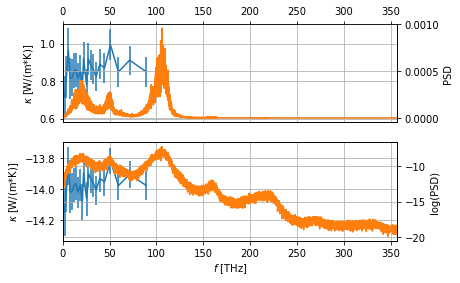

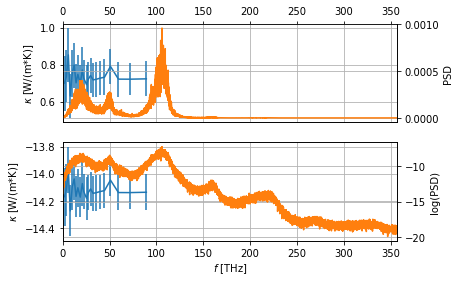

In [10]:
# Create HeatCurrent
jen, jjjen,TSKIP_LIST = k_compute(current_list=[jenab,jelab,vcmO],dt_fs=dt_fs,Tmean=Tmean,llvol=llvol,units='qepw')

In [11]:
#Filter the spectrum with F* = 20 THz
jf=jen.resample(fstar_THz=20,plot=False,PSD_FILTER_W=0.1)

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     357.14286 THz
 Resampling freq          f* =      19.84127 THz
 Sampling time         TSKIP =            18 steps
                             =        25.200 fs
 Original  n. of frequencies =         83859
 Resampled n. of frequencies =          4659
 PSD      @cutoff  (pre-filter&sample) ~      0.00029
                  (post-filter&sample) ~      0.00022
 log(PSD) @cutoff  (pre-filter&sample) ~     -8.76907
                  (post-filter&sample) ~     -9.38778
 min(PSD)          (pre-filter&sample) =      0.00000
 min(PSD)         (post-filter&sample) =      0.00000
 % of original PSD Power f<f* (pre-filter&sample)  = 13.832 %
-----------------------------------------------------



In [12]:
# COMPUTE kappa
jen.cepstral_analysis(Kmin_corrfactor=1)
jf.cepstral_analysis(Kmin_corrfactor=1)

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 119  (P* = 120, corr_factor = 1.000000)
  L_0*   =         -13.588836 +/-   0.068470
  S_0*   =           0.000004 +/-   0.000000
-----------------------------------------------------
  kappa* =           1.250337 +/-   0.085611  W/mK
-----------------------------------------------------

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 10  (P* = 11, corr_factor = 1.000000)
  L_0*   =         -13.865948 +/-   0.086116
  S_0*   =           0.000003 +/-   0.000000
-----------------------------------------------------
  kappa* =           0.947717 +/-   0.081614  W/mK
-----------------------------------------------------



<IPython.core.display.Javascript object>


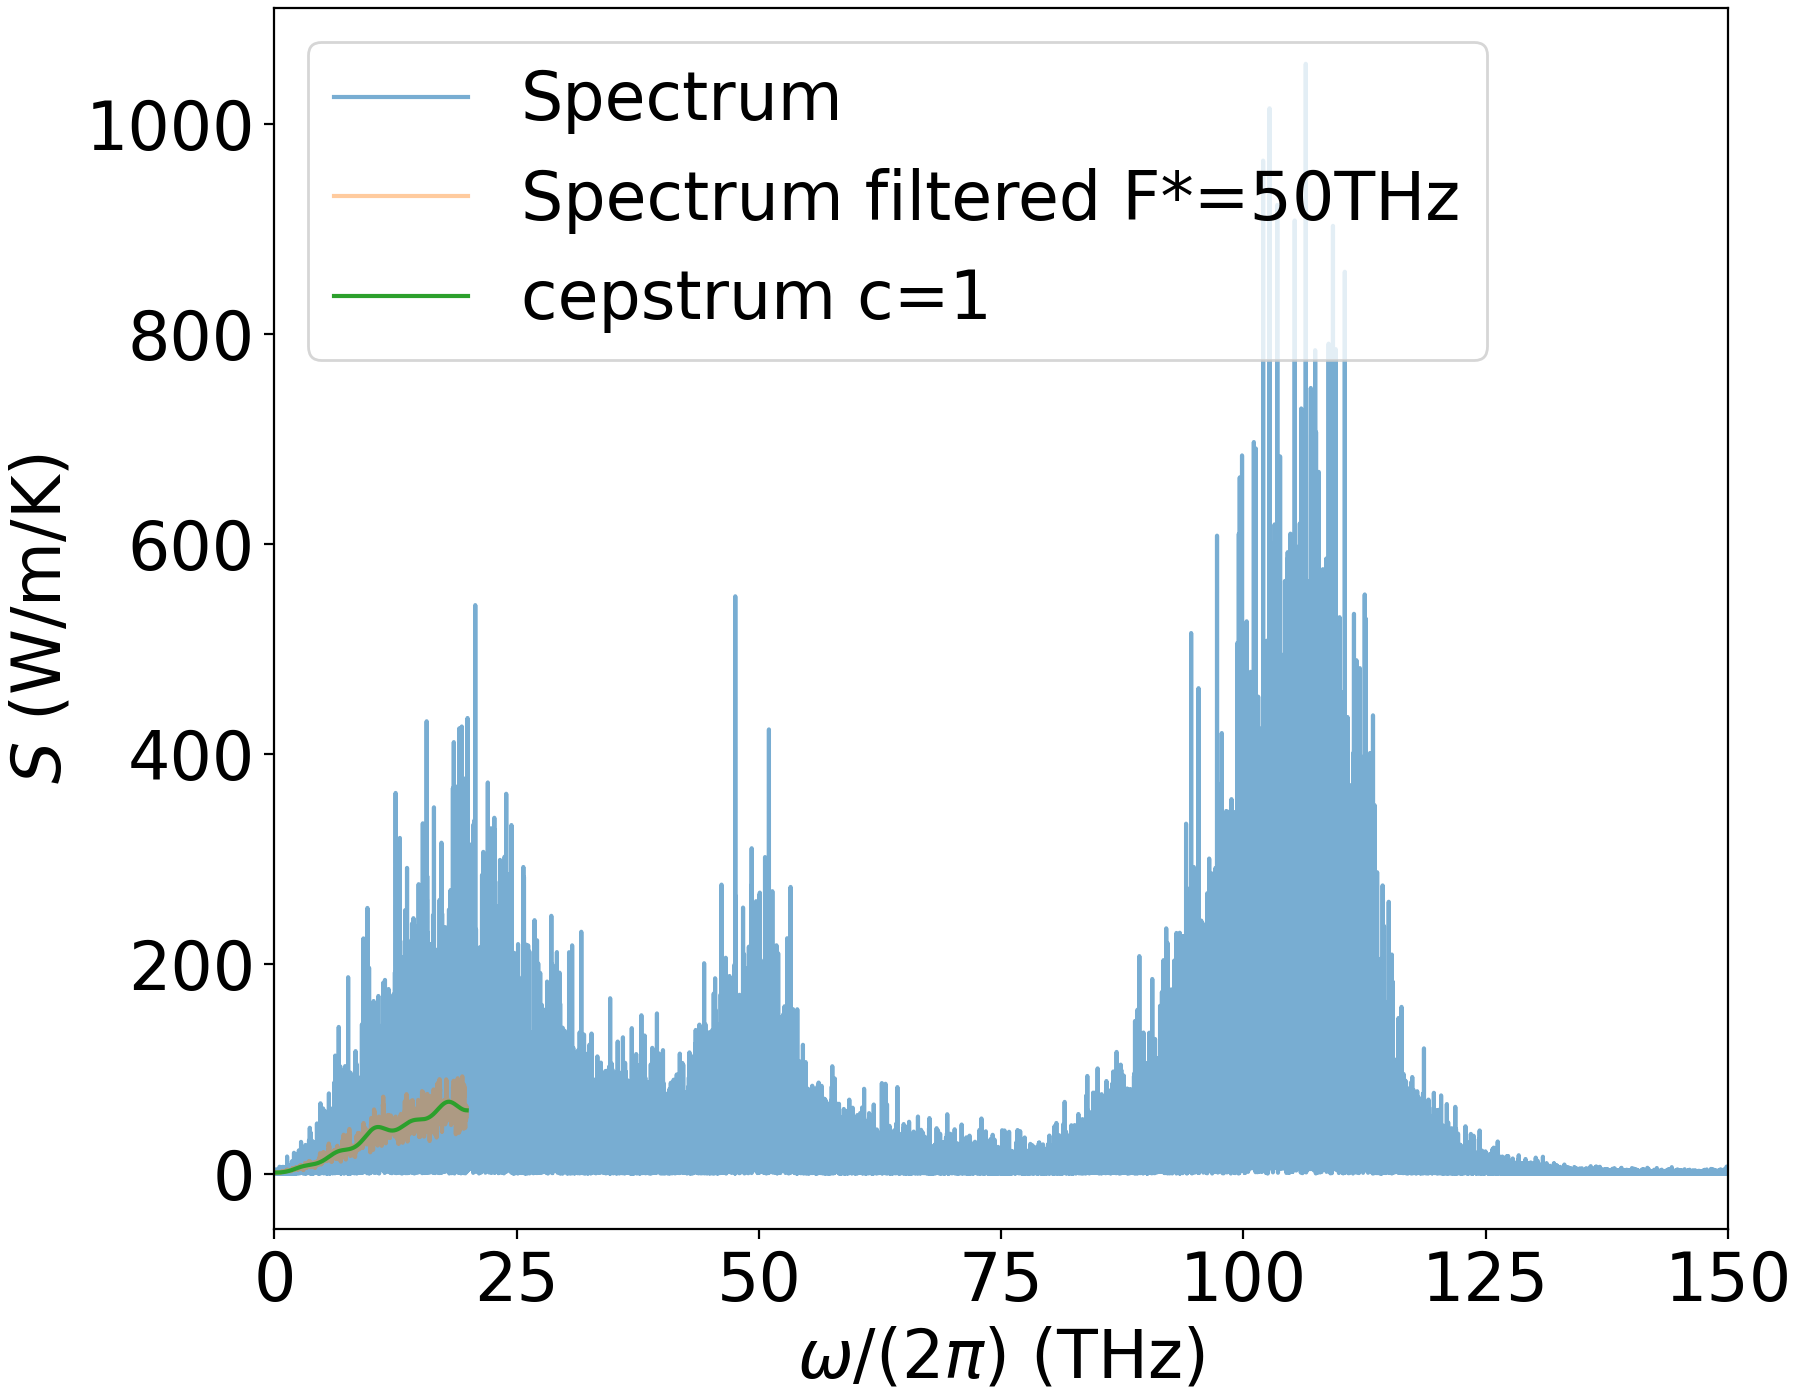

In [13]:
%matplotlib notebook
# plot the spectrum
fix,ax = plt.subplots(1, figsize=(9.0,7.0), constrained_layout=True)
ls=24
# 
ax.tick_params(axis='x', labelsize=ls)
ax.tick_params(axis='y', labelsize=ls)

j=jen
j1=jf



conv=j.KAPPA_SCALE/2

ax.set_xlim((0.,150))

alpha=0.6
gg=ax.plot(j.freqs_THz, j.psd*conv, label=r'Spectrum',alpha=alpha)

ff=ax.plot(j1.freqs_THz, j1.fpsd*conv, label=r'Spectrum filtered F*=50THz',alpha=0.4)
ff=ax.plot(j1.freqs_THz, j1.dct.psd*conv, label=r'cepstrum c=1')

ax.set_xlabel(r'$\omega/(2\pi)$ (THz)',fontsize=ls)
ax.set_ylabel(r'$S$ (W/m/K)',fontsize=ls)
ax.legend(loc='upper left',fontsize=ls)
#plt.savefig('Spettro_12.pdf',dpp=300)

<IPython.core.display.Javascript object>


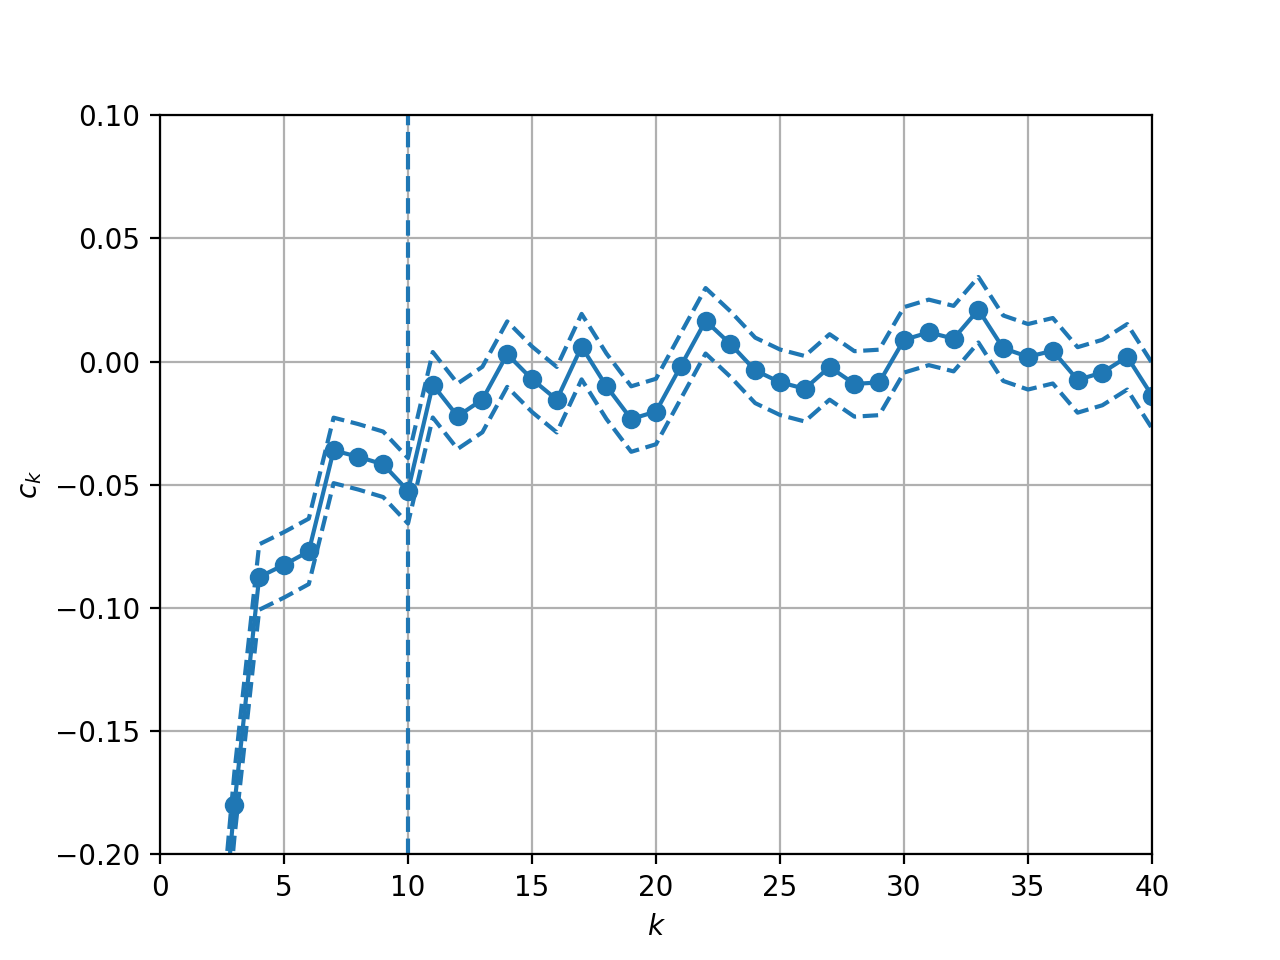

In [14]:
# plot the cepstral C_k vs k
# you can see that for k=20 the C_k are almost zero
ax=jf.plot_ck()
ax.set_ylim(-0.2,0.1)
ax.set_xlim(0,40)
ax.grid()

<IPython.core.display.Javascript object>


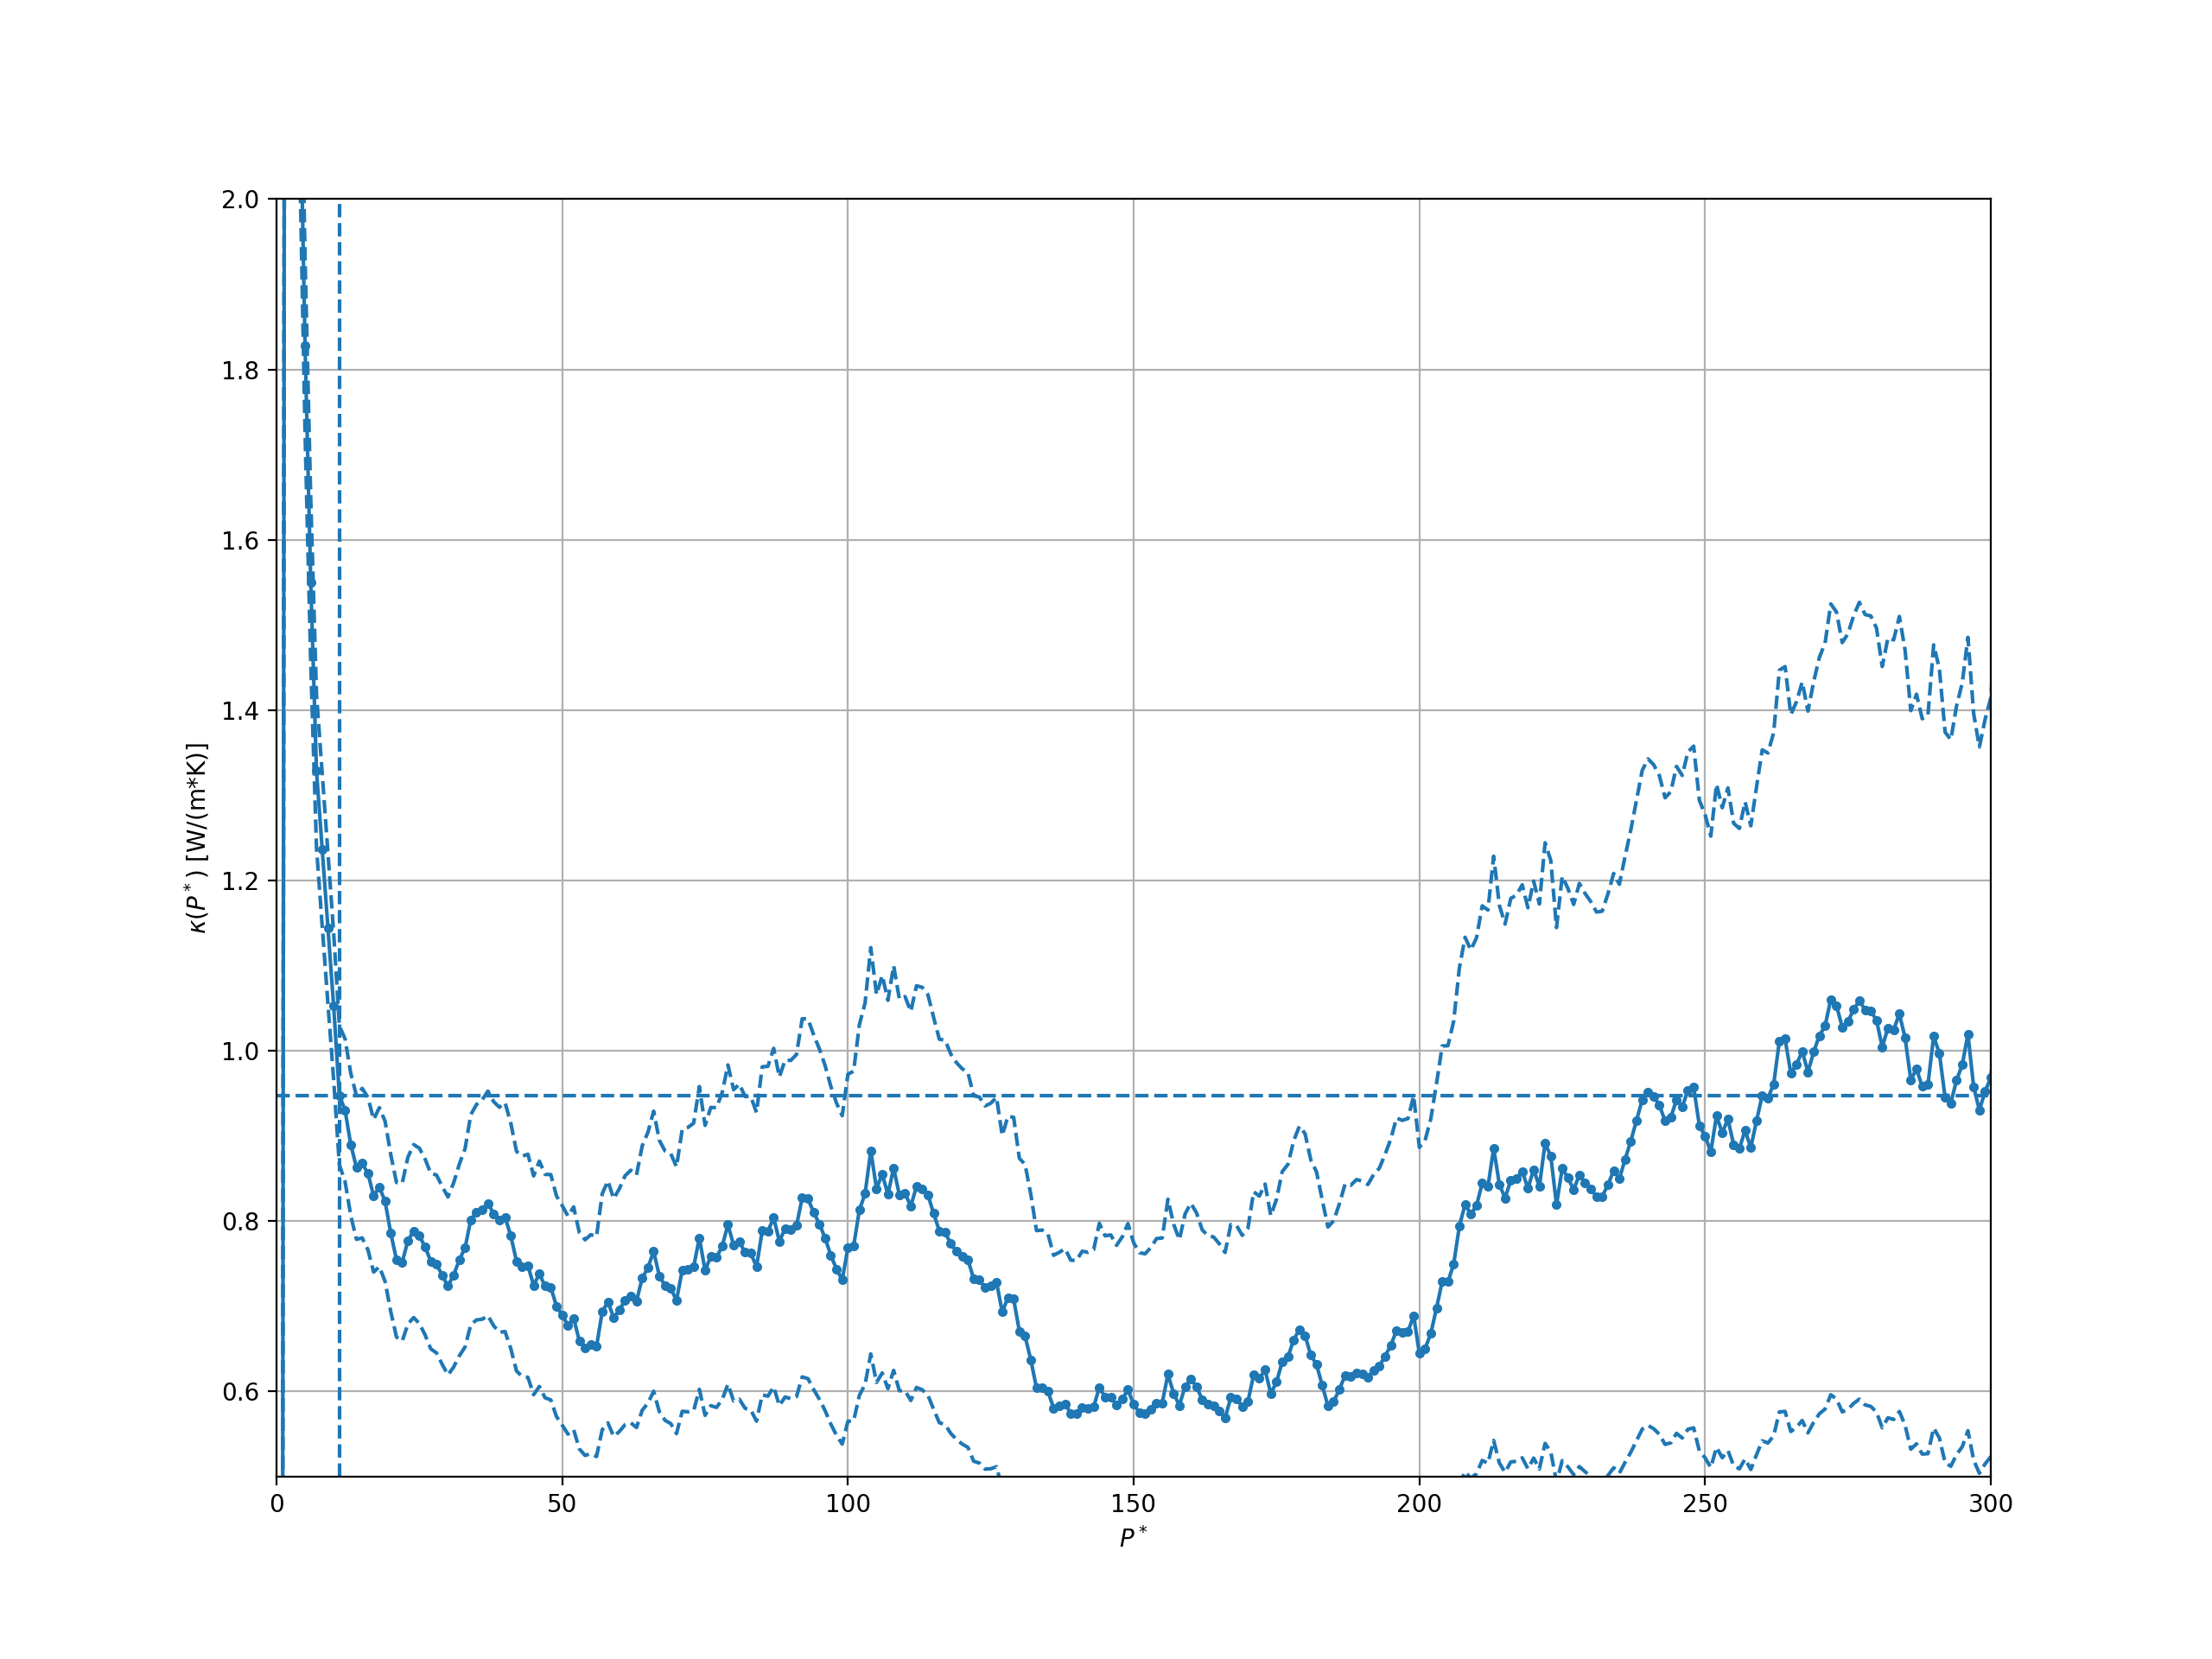

In [15]:
# plot kappa vs P*
# kappa do not change increasing P*
ax=jf.plot_kappa_Pstar()
ax.set_ylim(0.5,2)
ax.set_xlim(0,300)
ax.grid()

# $\kappa$ vs Fstar


## The picture below show that F*=20 is a fine coiche

<IPython.core.display.Javascript object>


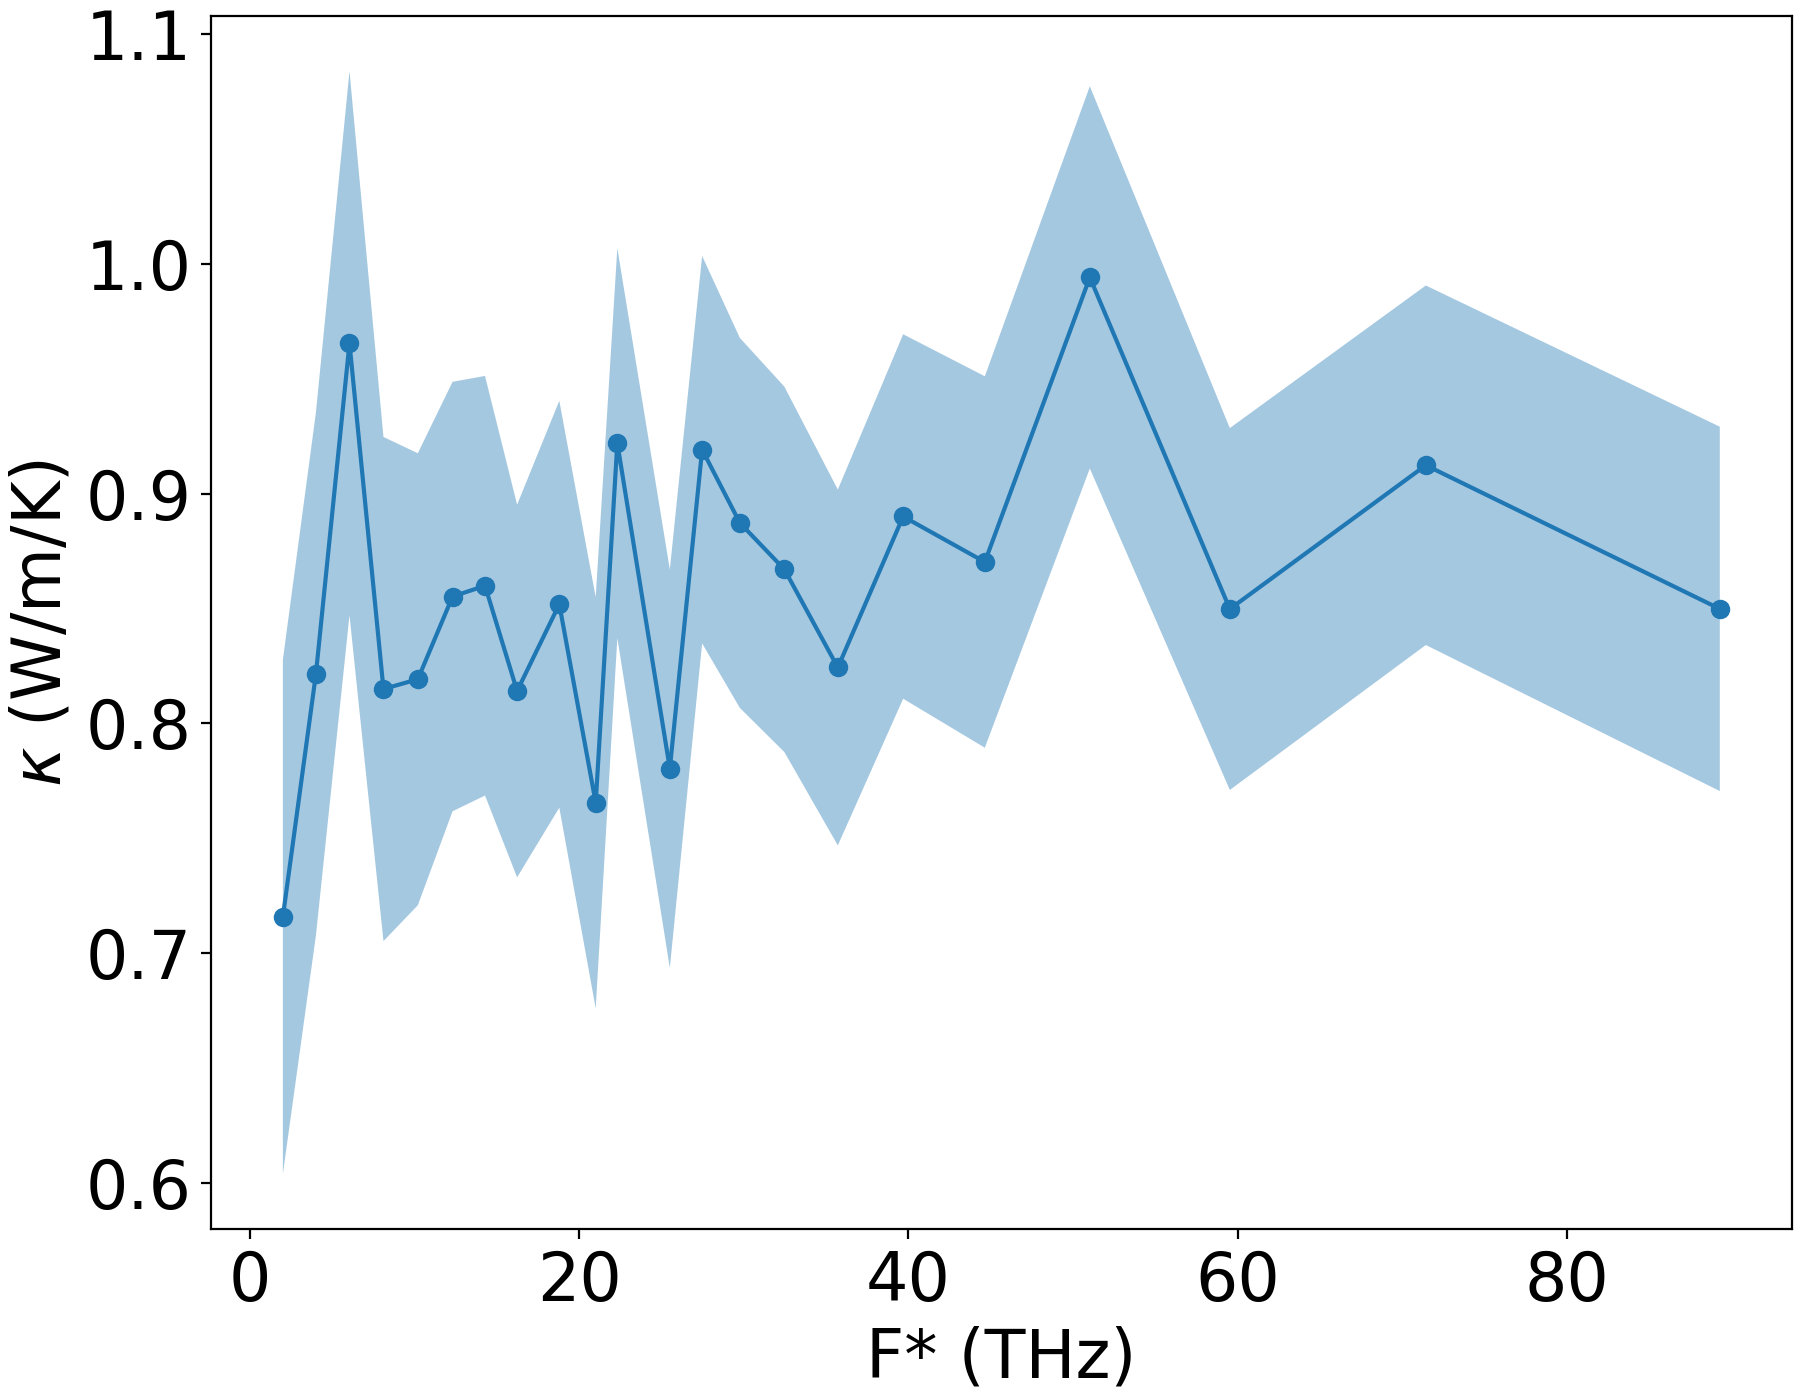

Text(0, 0.5, '$\\kappa$ (W/m/K)')

In [16]:
%matplotlib notebook


fix,ax = plt.subplots(1, figsize=(9.0,7.0), constrained_layout=True)
ls=24
# 

ax.tick_params(axis='x', labelsize=ls)
ax.tick_params(axis='y', labelsize=ls)
kappa_Kmin={}
kappa_Kmin_err={}
FSTAR_LIST = jen.Nyquist_f_THz/TSKIP_LIST
FEDE=np.ones(len(FSTAR_LIST))*4.2
FEDEerr=np.ones(len(FSTAR_LIST))*0.3
#for cor in corrfactors:
for cor in [1]:
    kappa_Kmin[cor] = np.array([j.kappa_Kmin for j in jjjen[cor]])
    kappa_Kmin_err[cor] = np.array([j.kappa_Kmin_std for j in jjjen[cor]])
    f1=ax.plot(FSTAR_LIST, kappa_Kmin[cor],'-o')
    ax.fill_between(FSTAR_LIST, kappa_Kmin[cor]-kappa_Kmin_err[cor],kappa_Kmin[cor]+kappa_Kmin_err[cor],alpha=0.4)
    #f1=ax.errorbar( FSTAR_LIST, kappa_Kmin, yerr=kappa_Kmin_err, capsize=4,label='c={}'.format(cor))
    #ax.axhline(np.mean(kappa_Kmin),ls='--',c=f1[0].get_color())

ax.set_xlabel('F* (THz)',fontsize=ls)
ax.set_ylabel(r'$\kappa$ (W/m/K)',fontsize=ls)
#ax.legend(loc='lower right',fontsize=ls,ncol=3)
#plt.savefig('kappa_corr_Fstar_1.pdf',dpp=300)

In [17]:
ltraj = current[-1,0] - current[0,0]
dstep = current[1,0] - current[0,0]
print(ltraj/(dstep)*dt_fs*1e-3,ltraj,dstep)

234.80099999945278 3354300.0 20.0


In [18]:
tr_ps = np.array([234.,200.,150.,100.,90.,80.,70.,60.,50.,40.,30.,20.,10.,5.])

print(tr_ps)
current_list=[jenab,jelab,vcmO]
#fstar = 13.8 è quella riportata nel paper
kappa_time(tr_ps,current_list,dt_fs,Tmean,llvol,units='qepw',fstar_THz=30.,Kmin_corrfactor=1)
jenTime_20THz ,jenTimef_20THz ,kappas_20THz = kappa_time(tr_ps=tr_ps,current_list=current_list,dt_fs=dt_fs,Tmean=Tmean,llvol=llvol,units='qepw',Kmin_corrfactor=1.,fstar_THz=20.)
jenTime_30THz ,jenTimef_30THz ,kappas_30THz = kappa_time(tr_ps=tr_ps,current_list=current_list,dt_fs=dt_fs,Tmean=Tmean,llvol=llvol,units='qepw',Kmin_corrfactor=1.,fstar_THz=30.)
jenTime_40THz ,jenTimef_40THz ,kappas_40THz = kappa_time(tr_ps=tr_ps,current_list=current_list,dt_fs=dt_fs,Tmean=Tmean,llvol=llvol,units='qepw',Kmin_corrfactor=1.,fstar_THz=40.)

[234. 200. 150. 100.  90.  80.  70.  60.  50.  40.  30.  20.  10.   5.]
end_step [167142. 142857. 107142.  71428.  64285.  57142.  50000.  42857.  35714.
  28571.  21428.  14285.   7142.   3571.] [233.9988 199.9998 149.9988  99.9992  89.999   79.9988  70.      59.9998
  49.9996  39.9994  29.9992  19.999    9.9988   4.9994]
0 167142.0
Using multicomponent code.
Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     357.14286 THz
 Resampling freq          f* =      29.76190 THz
 Sampling time         TSKIP =            12 steps
                             =        16.800 fs
 Original  n. of frequencies =         83572
 Resampled n. of frequencies =          6965
 PSD      @cutoff  (pre-filter&sample) ~      0.00010
                  (post-filter&sample) ~      0.00010
 log(PSD) @cutoff  (pre-filter&sample) ~     -9.77462
                  (post-filter

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     357.14286 THz
 Resampling freq          f* =      29.76190 THz
 Sampling time         TSKIP =            12 steps
                             =        16.800 fs
 Original  n. of frequencies =         21429
 Resampled n. of frequencies =          1786
 PSD      @cutoff  (pre-filter&sample) ~      0.00014
                  (post-filter&sample) ~      0.00011
 log(PSD) @cutoff  (pre-filter&sample) ~     -9.14072
                  (post-filter&sample) ~     -9.09502
 min(PSD)          (pre-filter&sample) =      0.00000
 min(PSD)         (post-filter&sample) =      0.00000
 % of original PSD Power f<f* (pre-filter&sample)  = 24.910 %
-----------------------------------------------------

-----------------------------------------------------
  CEPSTRAL ANALYSIS
----------------------------------------

end_step [167142. 142857. 107142.  71428.  64285.  57142.  50000.  42857.  35714.
  28571.  21428.  14285.   7142.   3571.] [233.9988 199.9998 149.9988  99.9992  89.999   79.9988  70.      59.9998
  49.9996  39.9994  29.9992  19.999    9.9988   4.9994]
0 167142.0
Using multicomponent code.
Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     357.14286 THz
 Resampling freq          f* =      19.84127 THz
 Sampling time         TSKIP =            18 steps
                             =        25.200 fs
 Original  n. of frequencies =         83572
 Resampled n. of frequencies =          4643
 PSD      @cutoff  (pre-filter&sample) ~      0.00031
                  (post-filter&sample) ~      0.00022
 log(PSD) @cutoff  (pre-filter&sample) ~     -8.82925
                  (post-filter&sample) ~     -9.28919
 min(PSD)          (pre-filter&sample) =      0.

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     357.14286 THz
 Resampling freq          f* =      19.84127 THz
 Sampling time         TSKIP =            18 steps
                             =        25.200 fs
 Original  n. of frequencies =         21429
 Resampled n. of frequencies =          1191
 PSD      @cutoff  (pre-filter&sample) ~      0.00032
                  (post-filter&sample) ~      0.00032
 log(PSD) @cutoff  (pre-filter&sample) ~     -8.27489
                  (post-filter&sample) ~     -8.30076
 min(PSD)          (pre-filter&sample) =      0.00000
 min(PSD)         (post-filter&sample) =      0.00000
 % of original PSD Power f<f* (pre-filter&sample)  = 13.928 %
-----------------------------------------------------

-----------------------------------------------------
  CEPSTRAL ANALYSIS
----------------------------------------

  28571.  21428.  14285.   7142.   3571.] [233.9988 199.9998 149.9988  99.9992  89.999   79.9988  70.      59.9998
  49.9996  39.9994  29.9992  19.999    9.9988   4.9994]
0 167142.0
Using multicomponent code.
Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     357.14286 THz
 Resampling freq          f* =      29.76190 THz
 Sampling time         TSKIP =            12 steps
                             =        16.800 fs
 Original  n. of frequencies =         83572
 Resampled n. of frequencies =          6965
 PSD      @cutoff  (pre-filter&sample) ~      0.00010
                  (post-filter&sample) ~      0.00010
 log(PSD) @cutoff  (pre-filter&sample) ~     -9.77462
                  (post-filter&sample) ~     -9.93514
 min(PSD)          (pre-filter&sample) =      0.00000
 min(PSD)         (post-filter&sample) =      0.00000
 % of original PSD Pow

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     357.14286 THz
 Resampling freq          f* =      29.76190 THz
 Sampling time         TSKIP =            12 steps
                             =        16.800 fs
 Original  n. of frequencies =         21429
 Resampled n. of frequencies =          1786
 PSD      @cutoff  (pre-filter&sample) ~      0.00014
                  (post-filter&sample) ~      0.00011
 log(PSD) @cutoff  (pre-filter&sample) ~     -9.14072
                  (post-filter&sample) ~     -9.09502
 min(PSD)          (pre-filter&sample) =      0.00000
 min(PSD)         (post-filter&sample) =      0.00000
 % of original PSD Power f<f* (pre-filter&sample)  = 24.910 %
-----------------------------------------------------

-----------------------------------------------------
  CEPSTRAL ANALYSIS
----------------------------------------

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     357.14286 THz
 Resampling freq          f* =      29.76190 THz
 Sampling time         TSKIP =            12 steps
                             =        16.800 fs
 Original  n. of frequencies =          1786
 Resampled n. of frequencies =           149
 PSD      @cutoff  (pre-filter&sample) ~      0.00016
                  (post-filter&sample) ~      0.00005
 log(PSD) @cutoff  (pre-filter&sample) ~     -8.75583
                  (post-filter&sample) ~     -9.81283
 min(PSD)          (pre-filter&sample) =      0.00000
 min(PSD)         (post-filter&sample) =      0.00000
 % of original PSD Power f<f* (pre-filter&sample)  = 28.165 %
-----------------------------------------------------

-----------------------------------------------------
  CEPSTRAL ANALYSIS
----------------------------------------

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     357.14286 THz
 Resampling freq          f* =      39.68254 THz
 Sampling time         TSKIP =             9 steps
                             =        12.600 fs
 Original  n. of frequencies =         28572
 Resampled n. of frequencies =          3175
 PSD      @cutoff  (pre-filter&sample) ~      0.00007
                  (post-filter&sample) ~      0.00014
 log(PSD) @cutoff  (pre-filter&sample) ~     -9.92773
                  (post-filter&sample) ~     -9.17628
 min(PSD)          (pre-filter&sample) =      0.00000
 min(PSD)         (post-filter&sample) =      0.00000
 % of original PSD Power f<f* (pre-filter&sample)  = 30.537 %
-----------------------------------------------------

-----------------------------------------------------
  CEPSTRAL ANALYSIS
----------------------------------------

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     357.14286 THz
 Resampling freq          f* =      39.68254 THz
 Sampling time         TSKIP =             9 steps
                             =        12.600 fs
 Original  n. of frequencies =          1786
 Resampled n. of frequencies =           199
 PSD      @cutoff  (pre-filter&sample) ~      0.00006
                  (post-filter&sample) ~      0.00001
 log(PSD) @cutoff  (pre-filter&sample) ~     -9.64768
                  (post-filter&sample) ~    -11.63671
 min(PSD)          (pre-filter&sample) =      0.00000
 min(PSD)         (post-filter&sample) =      0.00000
 % of original PSD Power f<f* (pre-filter&sample)  = 34.002 %
-----------------------------------------------------

-----------------------------------------------------
  CEPSTRAL ANALYSIS
----------------------------------------

<IPython.core.display.Javascript object>


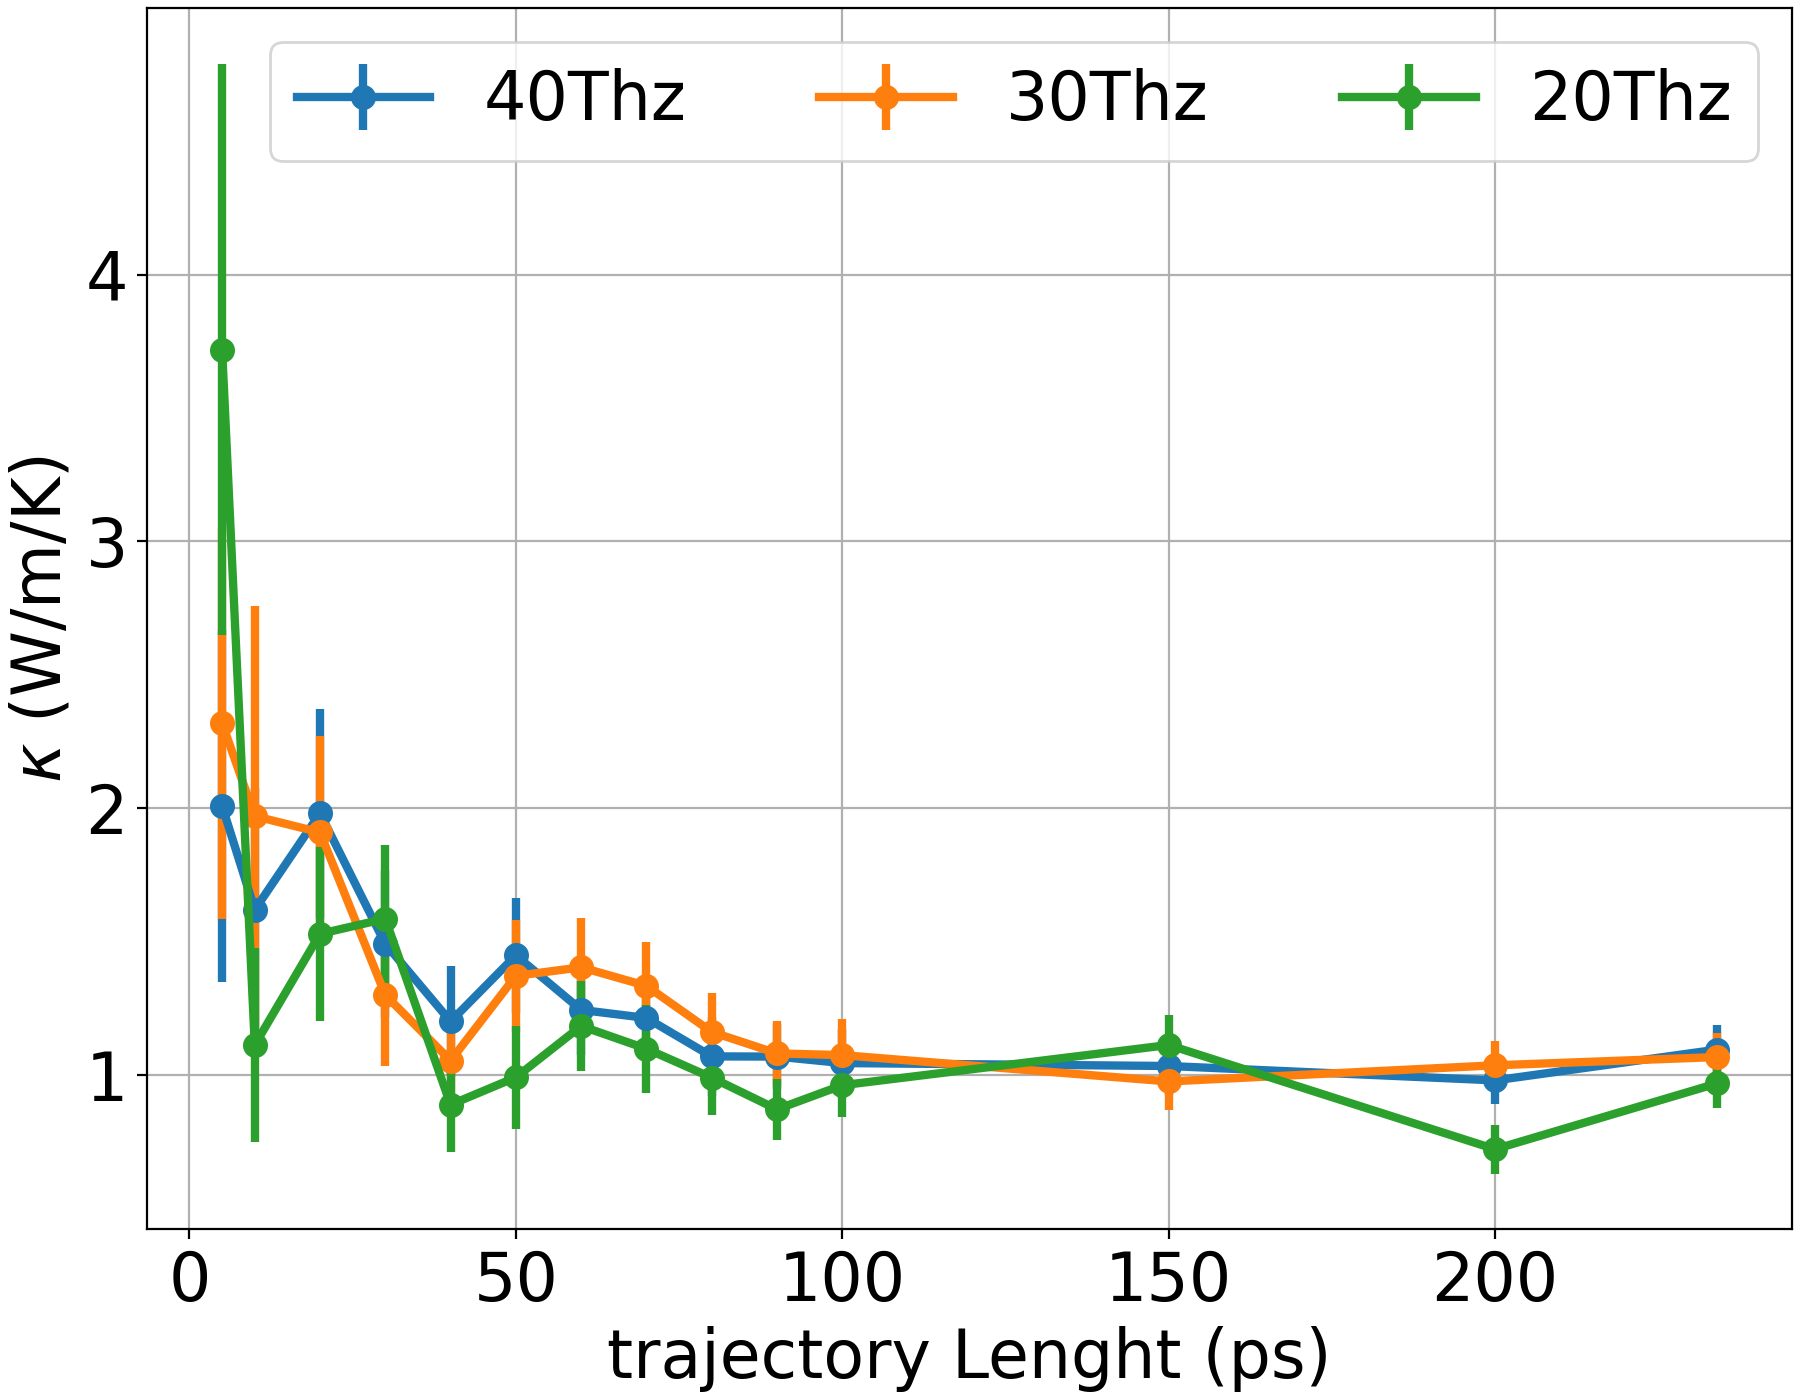

In [19]:
%matplotlib notebook


fix,ax = plt.subplots(1, figsize=(9.0,7.0), constrained_layout=True)
ls=24
# 

ax.tick_params(axis='x', labelsize=ls)
ax.tick_params(axis='y', labelsize=ls)

#f1=ax.plot(FSTAR_LIST, kappa_Kmin[cor],'-o',label='c={}'.format(cor))
ax.errorbar(kappas_40THz[:,0],kappas_40THz[:,1],kappas_40THz[:,2],ls='-',marker='o',lw=3,ms=8,label='40Thz')
ax.errorbar(kappas_30THz[:,0],kappas_30THz[:,1],kappas_30THz[:,2],ls='-',marker='o',lw=3,ms=8,label='30Thz')
ax.errorbar(kappas_20THz[:,0],kappas_20THz[:,1],kappas_20THz[:,2],ls='-',marker='o',lw=3,ms=8,label='20Thz')

ax.grid()



ax.set_xlabel('trajectory Lenght (ps)',fontsize=ls)
ax.set_ylabel(r'$\kappa$ (W/m/K)',fontsize=ls)
ax.legend(loc='upper right',fontsize=ls,ncol=3)


# ICEX 

## analisys IceX trajectory at 1488. K 
data taken from [3,4]

[3] Grasselli, L. Stixrude, S. Baroni, Heat and charge transport in H2O at ice-giant conditions from ab initio molecular dynamics simulations, Nature Communications 11 (1) (2020) 3605.

[4]Grasselli, L. Stixrude, S. Baroni, Heat and charge transport in h2o at ice-giant conditions from ab initio molecular dynamics simulations. doi:10.24435/materialscloud:hn-6f , URL https://archive.materialscloud.org/record/2020.73

In [44]:
thermoiceX =  np.load('solid_iceX_1488K/solid_iceX_1488K_thermocepstrum.npy',allow_pickle=True)
thermoiceX

array({'J_E': array([[ 0.05937636,  0.05400789, -0.07013992],
       [ 0.05879341, -0.00014588, -0.03344427],
       [ 0.05504954, -0.05632591,  0.02422318],
       ...,
       [ 0.01098129,  0.12350925,  0.04677368],
       [-0.02465618,  0.11302839,  0.07599277],
       [-0.05673417,  0.06290756,  0.07352498]]), 'J_electrons': array([[ 0.06958546,  0.04877535, -0.06257819],
       [ 0.0527325 ,  0.0087349 , -0.04497569],
       [ 0.04212428, -0.03482783, -0.00799692],
       ...,
       [ 0.03248199,  0.10774174,  0.07010829],
       [-0.0020224 ,  0.08753875,  0.10102711],
       [-0.04049088,  0.04134784,  0.10804847]]), 'J_Z': array([[-0.07856478, -0.01083178,  0.04949979],
       [-0.0348859 , -0.01551537,  0.05089162],
       [ 0.00174887, -0.0086566 ,  0.04519696],
       ...,
       [-0.06359179, -0.05444411, -0.09213597],
       [-0.03222995, -0.02852397, -0.11859583],
       [ 0.00717164,  0.00670081, -0.13037496]]), 'Temperature': 1488.3000979733756, 'Volume_A': 1088.091621

In [45]:
#dataen = np.loadtxt('multi_currenti2_3.0.4fs.out',skiprows=1)
#dataen = thermo
#jen = dataen[:,3:6]
#vcmO = dataen[:,6:9]
#vcmH = dataen[:,9:]
jeniceX = thermoiceX.item()['J_E']
JZ =thermoiceX.item()['J_Z']
jelIceX = thermoiceX.item()['J_electrons']
TmeanIceX= thermoiceX.item()['Temperature']
llvolIceX = thermoiceX.item()['Volume_A']
dt_fsIceX = thermoiceX.item()['DT_FS']
print(TmeanIceX,llvolIceX,dt_fsIceX)



1488.3000979733756 1088.0916211942474 1.4512800000000001


Using multicomponent code.
[172  86  57  43  34  28  24  21  19  17  15  14  13  12  11  10   9   8
   7   6   5   4]
TSKIP =  172 - FSTAR =  2.00304 THz
Using multicomponent code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 1  (P* = 2, corr_factor = 1.000000)
  L_0*   =          -8.886380 +/-   0.115118
  S_0*   =           0.000246 +/-   0.000028
-----------------------------------------------------
  kappa* =          21.037036 +/-   2.421734  W/mK
-----------------------------------------------------

TSKIP =   86 - FSTAR =  4.00609 THz
Using multicomponent code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 2  (P* = 3, corr_factor = 1.000000)
  L_0*   =          -9.015511 +/-   0.105088
  S_0*   =           0.000216 +/-   0.000023
-----------------------------------------------------
  kapp

<ipython-input-30-44e145d3f49f>:33: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  TSKIP_LIST = np.array(TSKIP_LIST,dtype=np.int)


Using multicomponent code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 6  (P* = 7, corr_factor = 1.000000)
  L_0*   =          -9.146896 +/-   0.079577
  S_0*   =           0.000190 +/-   0.000015
-----------------------------------------------------
  kappa* =          16.212268 +/-   1.290117  W/mK
-----------------------------------------------------

TSKIP =   17 - FSTAR =  20.2661 THz
Using multicomponent code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 6  (P* = 7, corr_factor = 1.000000)
  L_0*   =          -9.233902 +/-   0.075266
  S_0*   =           0.000174 +/-   0.000013
-----------------------------------------------------
  kappa* =          14.861321 +/-   1.118551  W/mK
-----------------------------------------------------

TSKIP =   15 - FSTAR =  22.9682 THz
Using multicompone

<IPython.core.display.Javascript object>


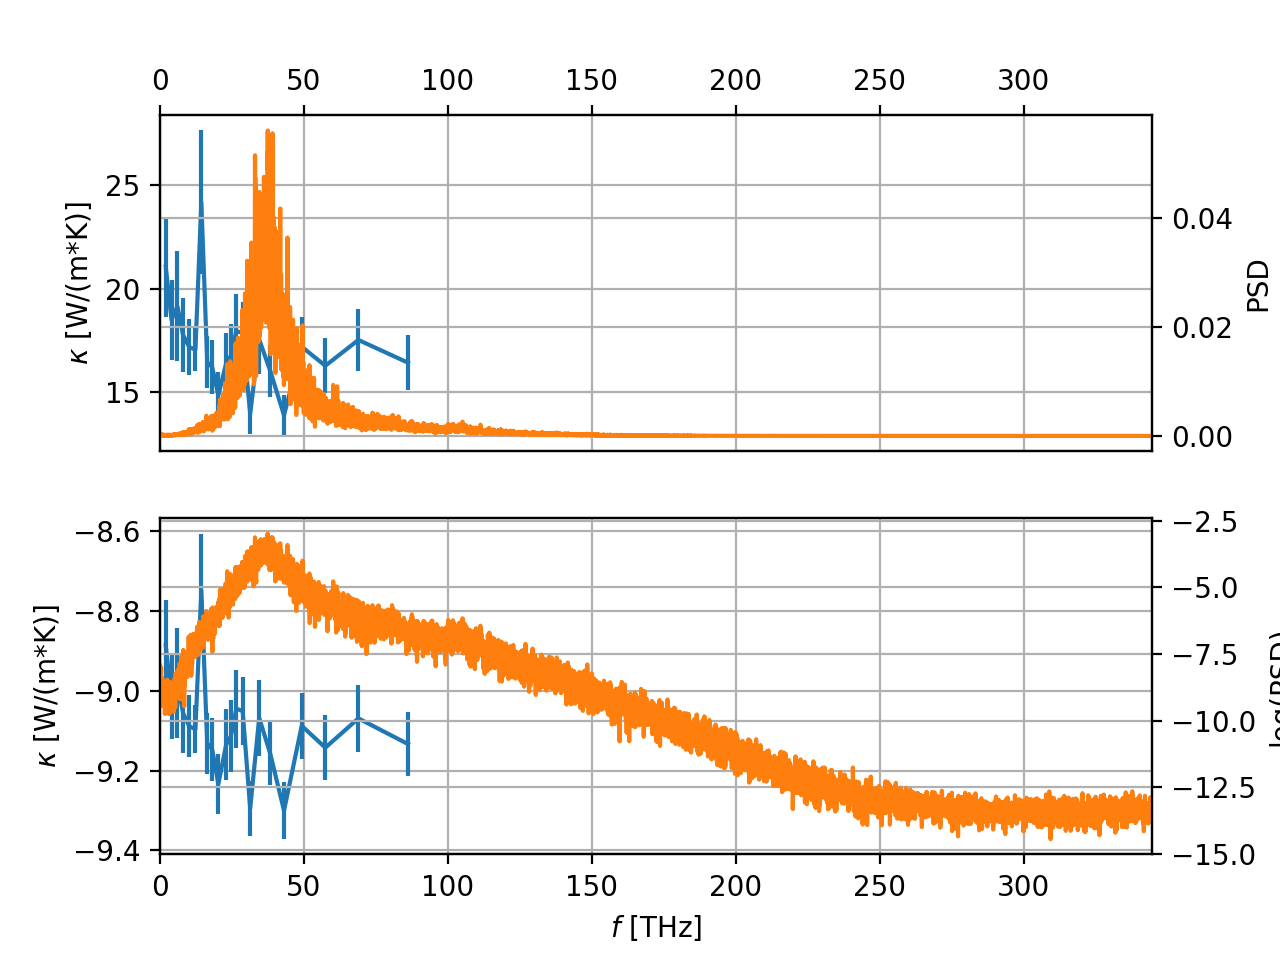

[172  86  57  43  34  28  24  21  19  17  15  14  13  12  11  10   9   8
   7   6   5   4]
TSKIP =  172 - FSTAR =  2.00304 THz
Using multicomponent code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 2  (P* = 3, corr_factor = 2.000000)
  L_0*   =          -8.939971 +/-   0.148616
  S_0*   =           0.000233 +/-   0.000035
-----------------------------------------------------
  kappa* =          19.939314 +/-   2.963306  W/mK
-----------------------------------------------------

TSKIP =   86 - FSTAR =  4.00609 THz
Using multicomponent code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 4  (P* = 5, corr_factor = 2.000000)
  L_0*   =          -8.929577 +/-   0.140990
  S_0*   =           0.000236 +/-   0.000033
-----------------------------------------------------
  kappa* =          20.147635 +/-

<ipython-input-30-44e145d3f49f>:33: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  TSKIP_LIST = np.array(TSKIP_LIST,dtype=np.int)


Using multicomponent code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 10  (P* = 11, corr_factor = 2.000000)
  L_0*   =          -9.090609 +/-   0.106326
  S_0*   =           0.000201 +/-   0.000021
-----------------------------------------------------
  kappa* =          17.150978 +/-   1.823593  W/mK
-----------------------------------------------------

TSKIP =   19 - FSTAR =  18.1328 THz
Using multicomponent code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 12  (P* = 13, corr_factor = 2.000000)
  L_0*   =          -9.098922 +/-   0.110353
  S_0*   =           0.000199 +/-   0.000022
-----------------------------------------------------
  kappa* =          17.008997 +/-   1.876992  W/mK
-----------------------------------------------------

TSKIP =   17 - FSTAR =  20.2661 THz
Using multicom

<IPython.core.display.Javascript object>


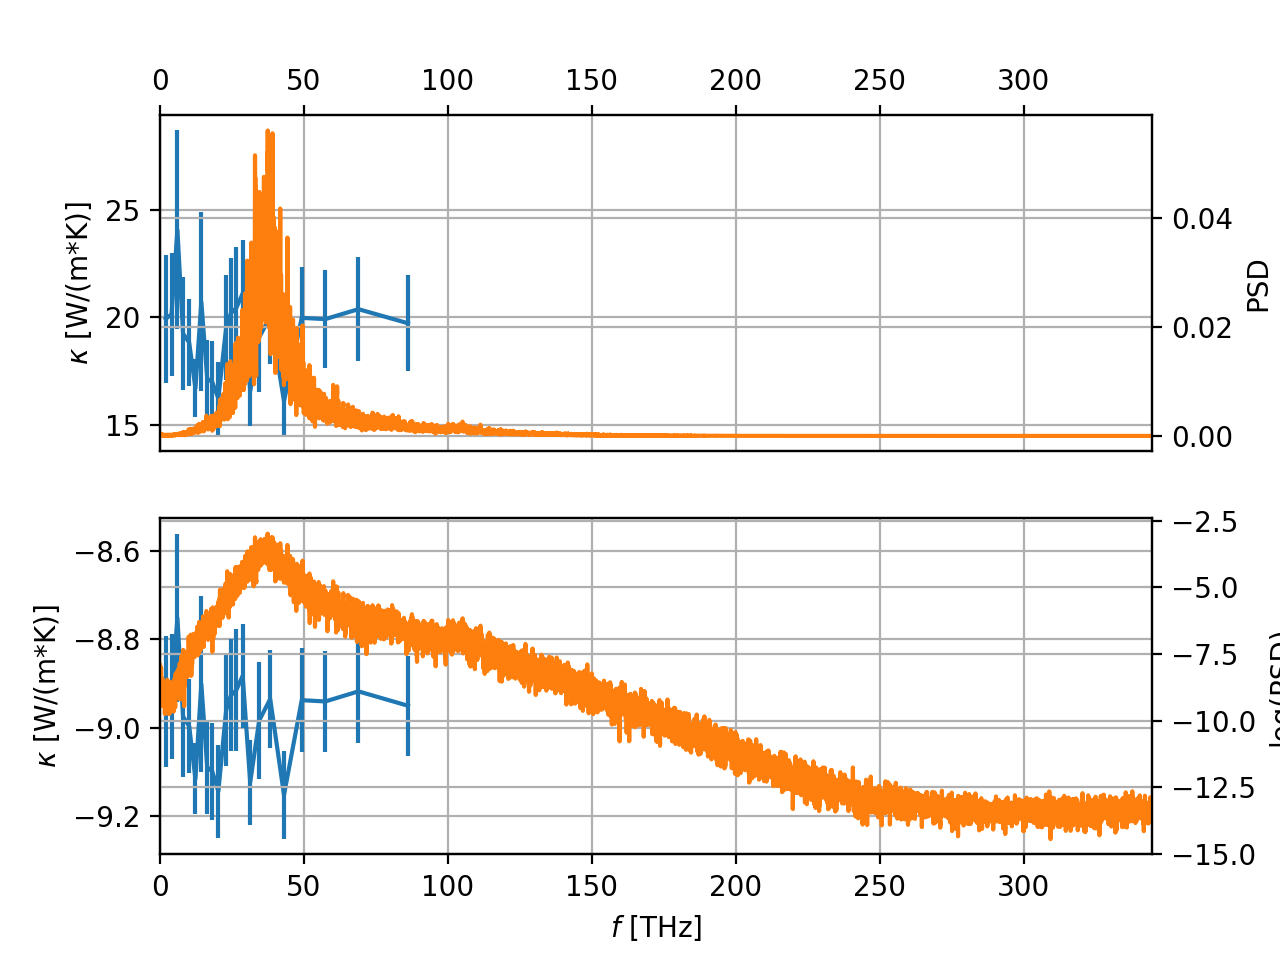

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     344.52346 THz
 Resampling freq          f* =      38.28038 THz
 Sampling time         TSKIP =             9 steps
                             =        13.062 fs
 Original  n. of frequencies =         25166
 Resampled n. of frequencies =          2797
 PSD      @cutoff  (pre-filter&sample) ~      0.03250
                  (post-filter&sample) ~      0.02675
 log(PSD) @cutoff  (pre-filter&sample) ~     -3.66968
                  (post-filter&sample) ~     -3.73035
 min(PSD)          (pre-filter&sample) =      0.00000
 min(PSD)         (post-filter&sample) =      0.00001
 % of original PSD Power f<f* (pre-filter&sample)  = 46.145 %
-----------------------------------------------------

-----------------------------------------------------
  CEPSTRAL ANALYSIS
----------------------------------------

In [47]:
jenIcex,jjjenIcex,TSKIP_LIST = k_compute(current_list=[jeniceX,JZ],dt_fs=dt_fsIceX,Tmean=TmeanIceX,llvol=llvolIceX,units='qepw')
jenIcexf = jenIcex.resample(fstar_THz=40,plot=False,PSD_FILTER_W=0.1)
jenIcexf.cepstral_analysis() 

<IPython.core.display.Javascript object>


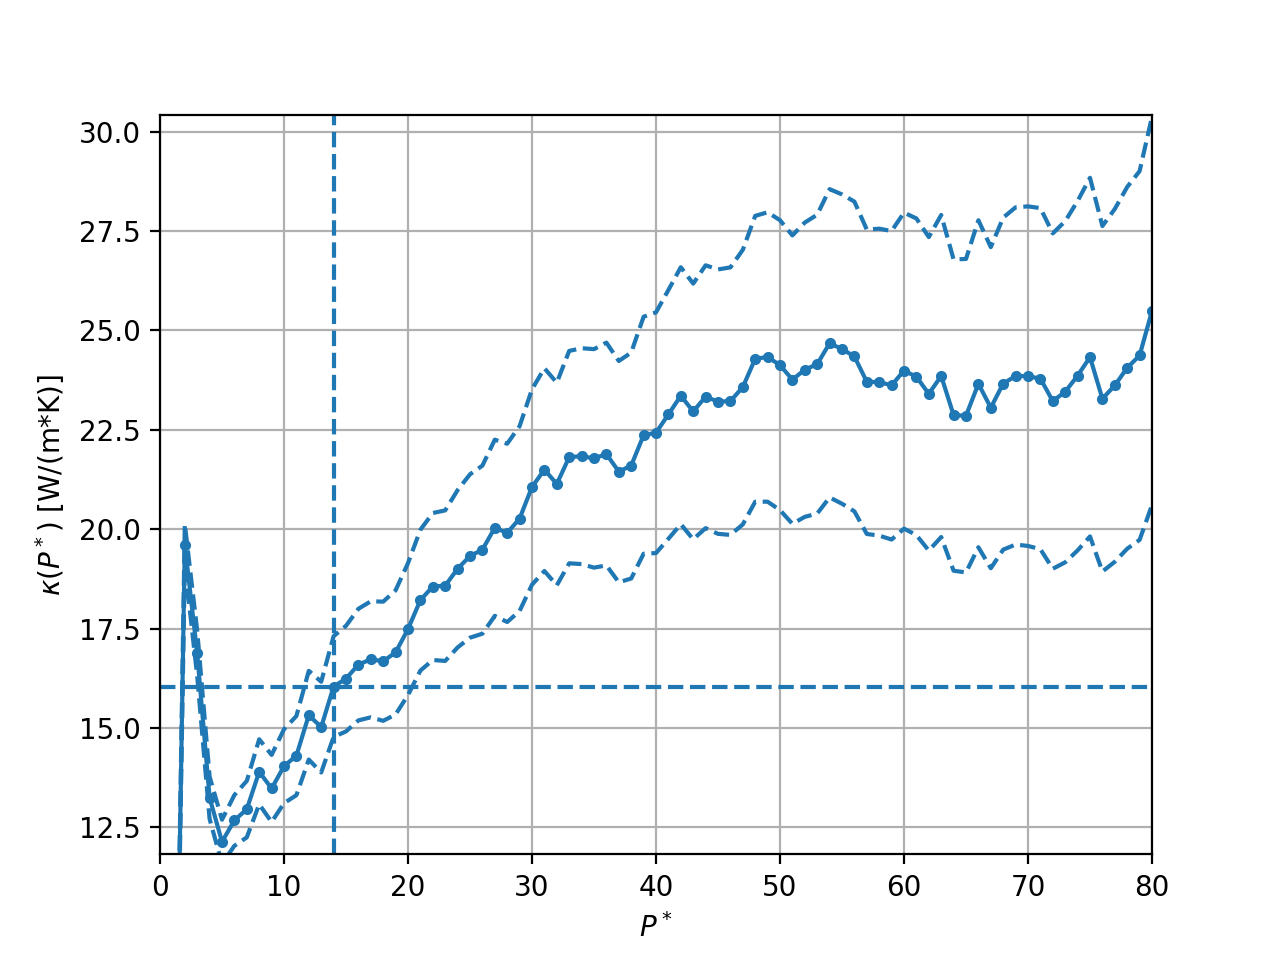

In [48]:
ax=jenIcexf.plot_kappa_Pstar()
#ax.set_ylim(0.5,2)
ax.set_xlim(0,80)
ax.grid()

<IPython.core.display.Javascript object>


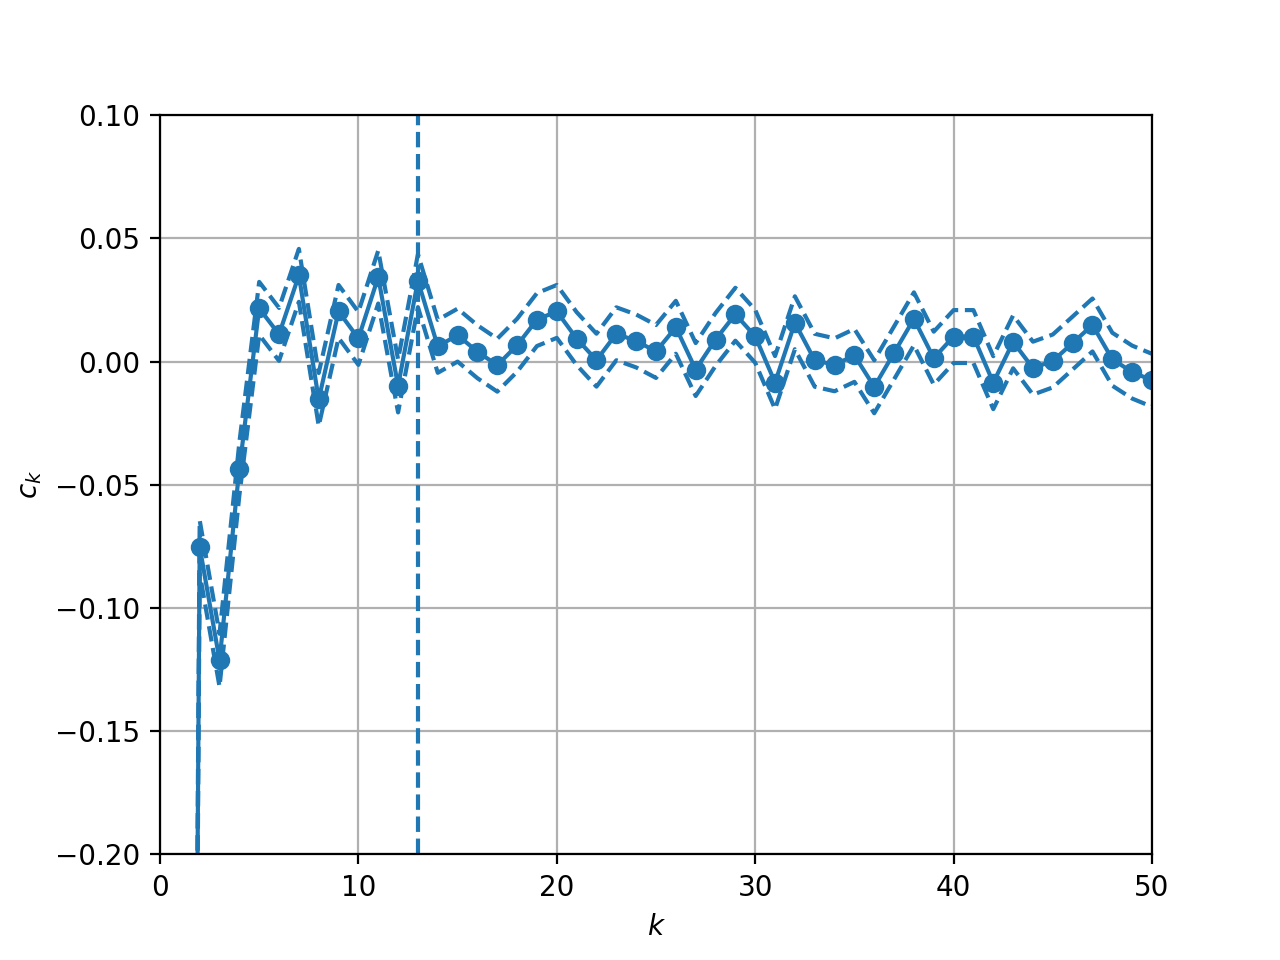

In [49]:
ax=jenIcexf.plot_ck()
ax.set_ylim(-0.2,0.1)
ax.set_xlim(0,50)
ax.grid()

<IPython.core.display.Javascript object>


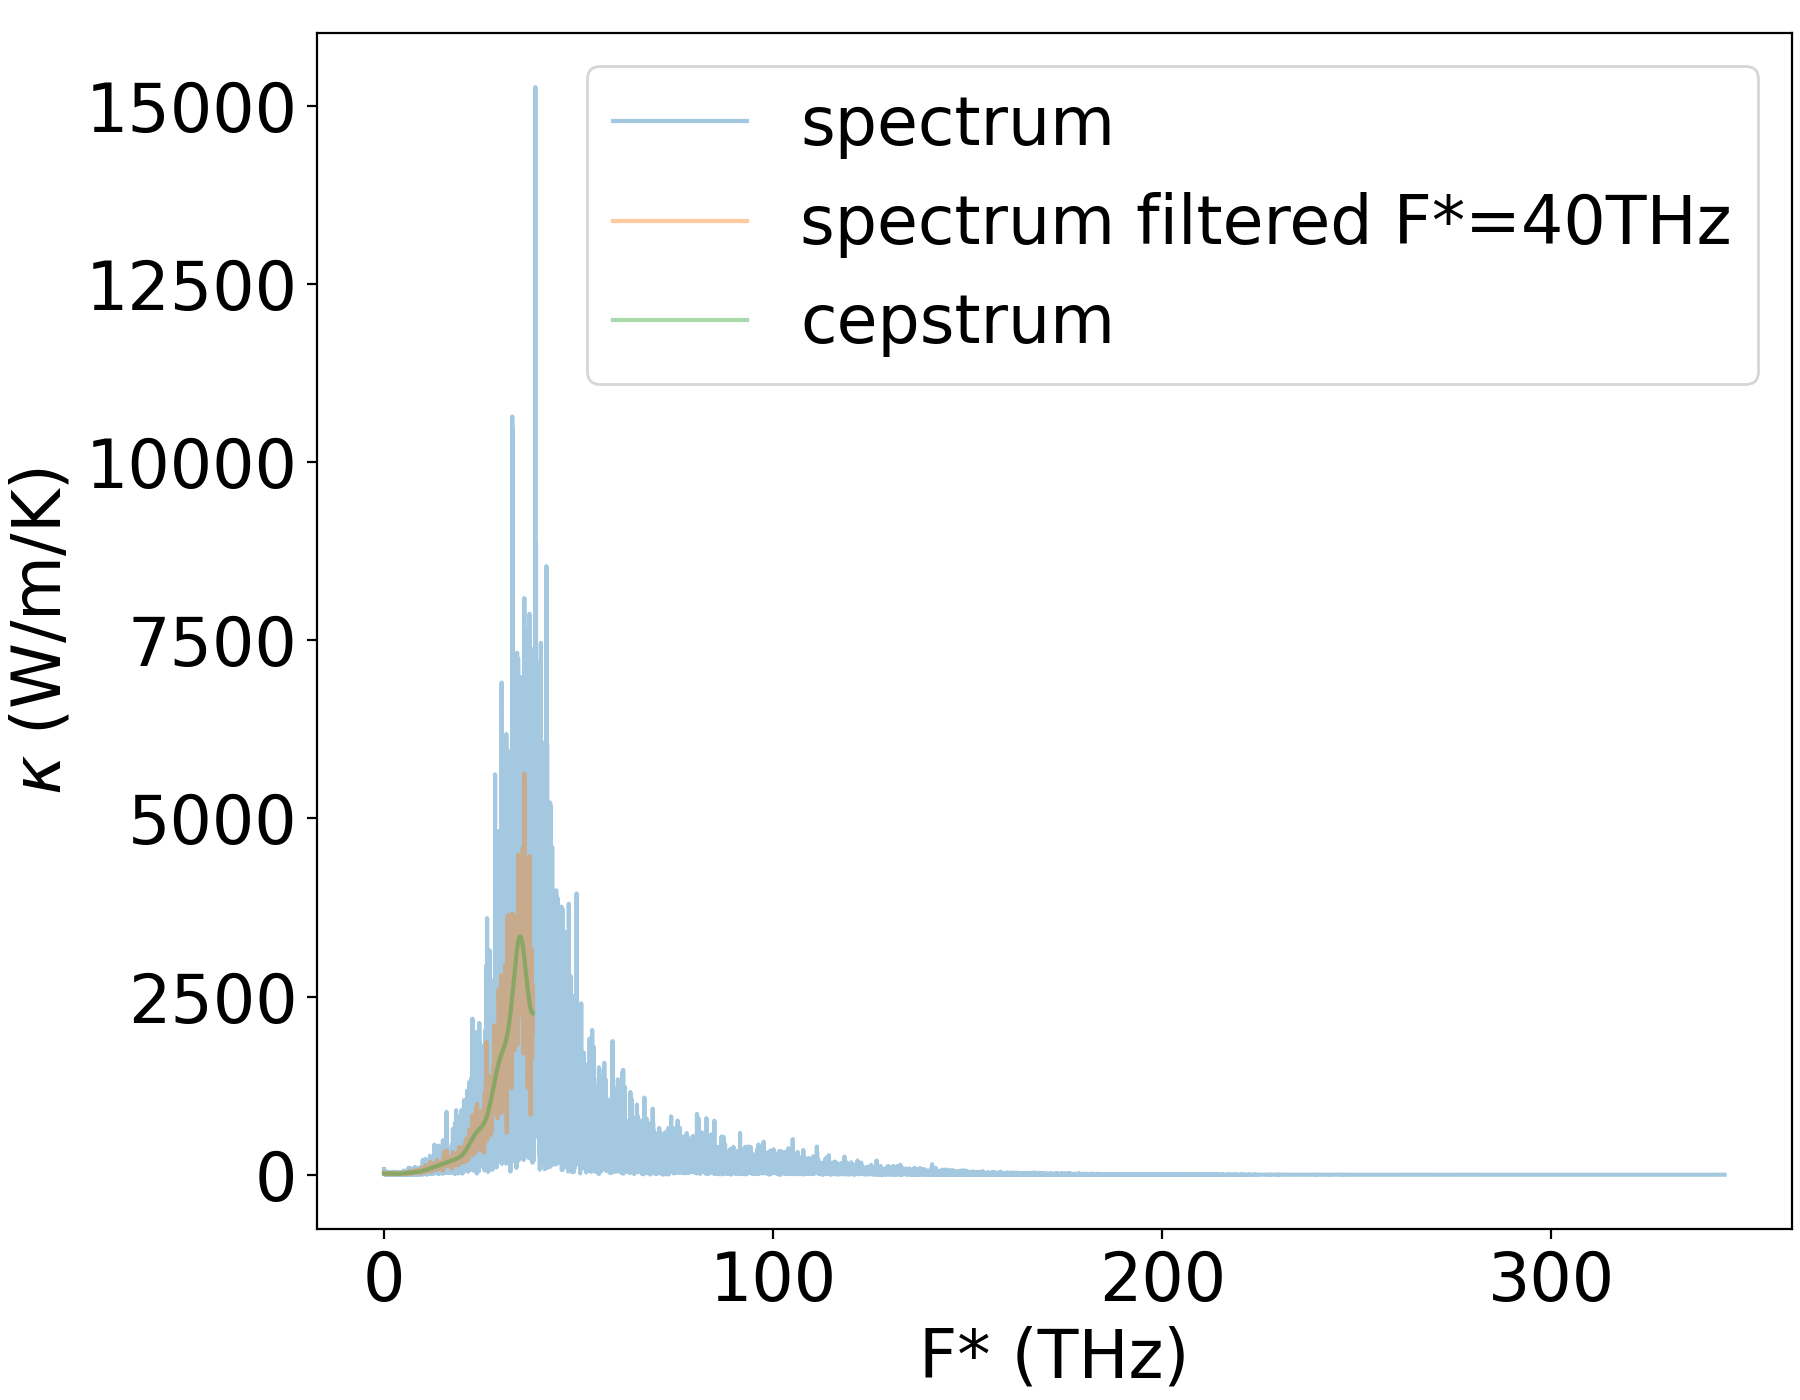

In [50]:
fix,ax = plt.subplots(1, figsize=(9.0,7.0), constrained_layout=True)
ls=24
#
ax.tick_params(axis='x', labelsize=ls)
ax.tick_params(axis='y', labelsize=ls)

#FSTAR_LIST = abjen.Nyquist_f_THz/TSKIP_LIST
kscale=jenIcex.KAPPA_SCALE*0.5


f1=ax.plot(jenIcex.freqs_THz, jenIcex.psd *kscale ,label='spectrum',alpha=0.4)
f1=ax.plot(jenIcexf.freqs_THz, jenIcexf.fpsd *kscale ,label='spectrum filtered F*=40THz',alpha=0.4)
ax.plot(jenIcexf.freqs_THz, jenIcexf.dct.psd *kscale ,label='cepstrum',alpha=0.4)

ax.set_xlabel('F* (THz)',fontsize=ls)
ax.set_ylabel(r'$\kappa$ (W/m/K)',fontsize=ls)
ax.legend(loc='upper right',fontsize=ls)

<IPython.core.display.Javascript object>


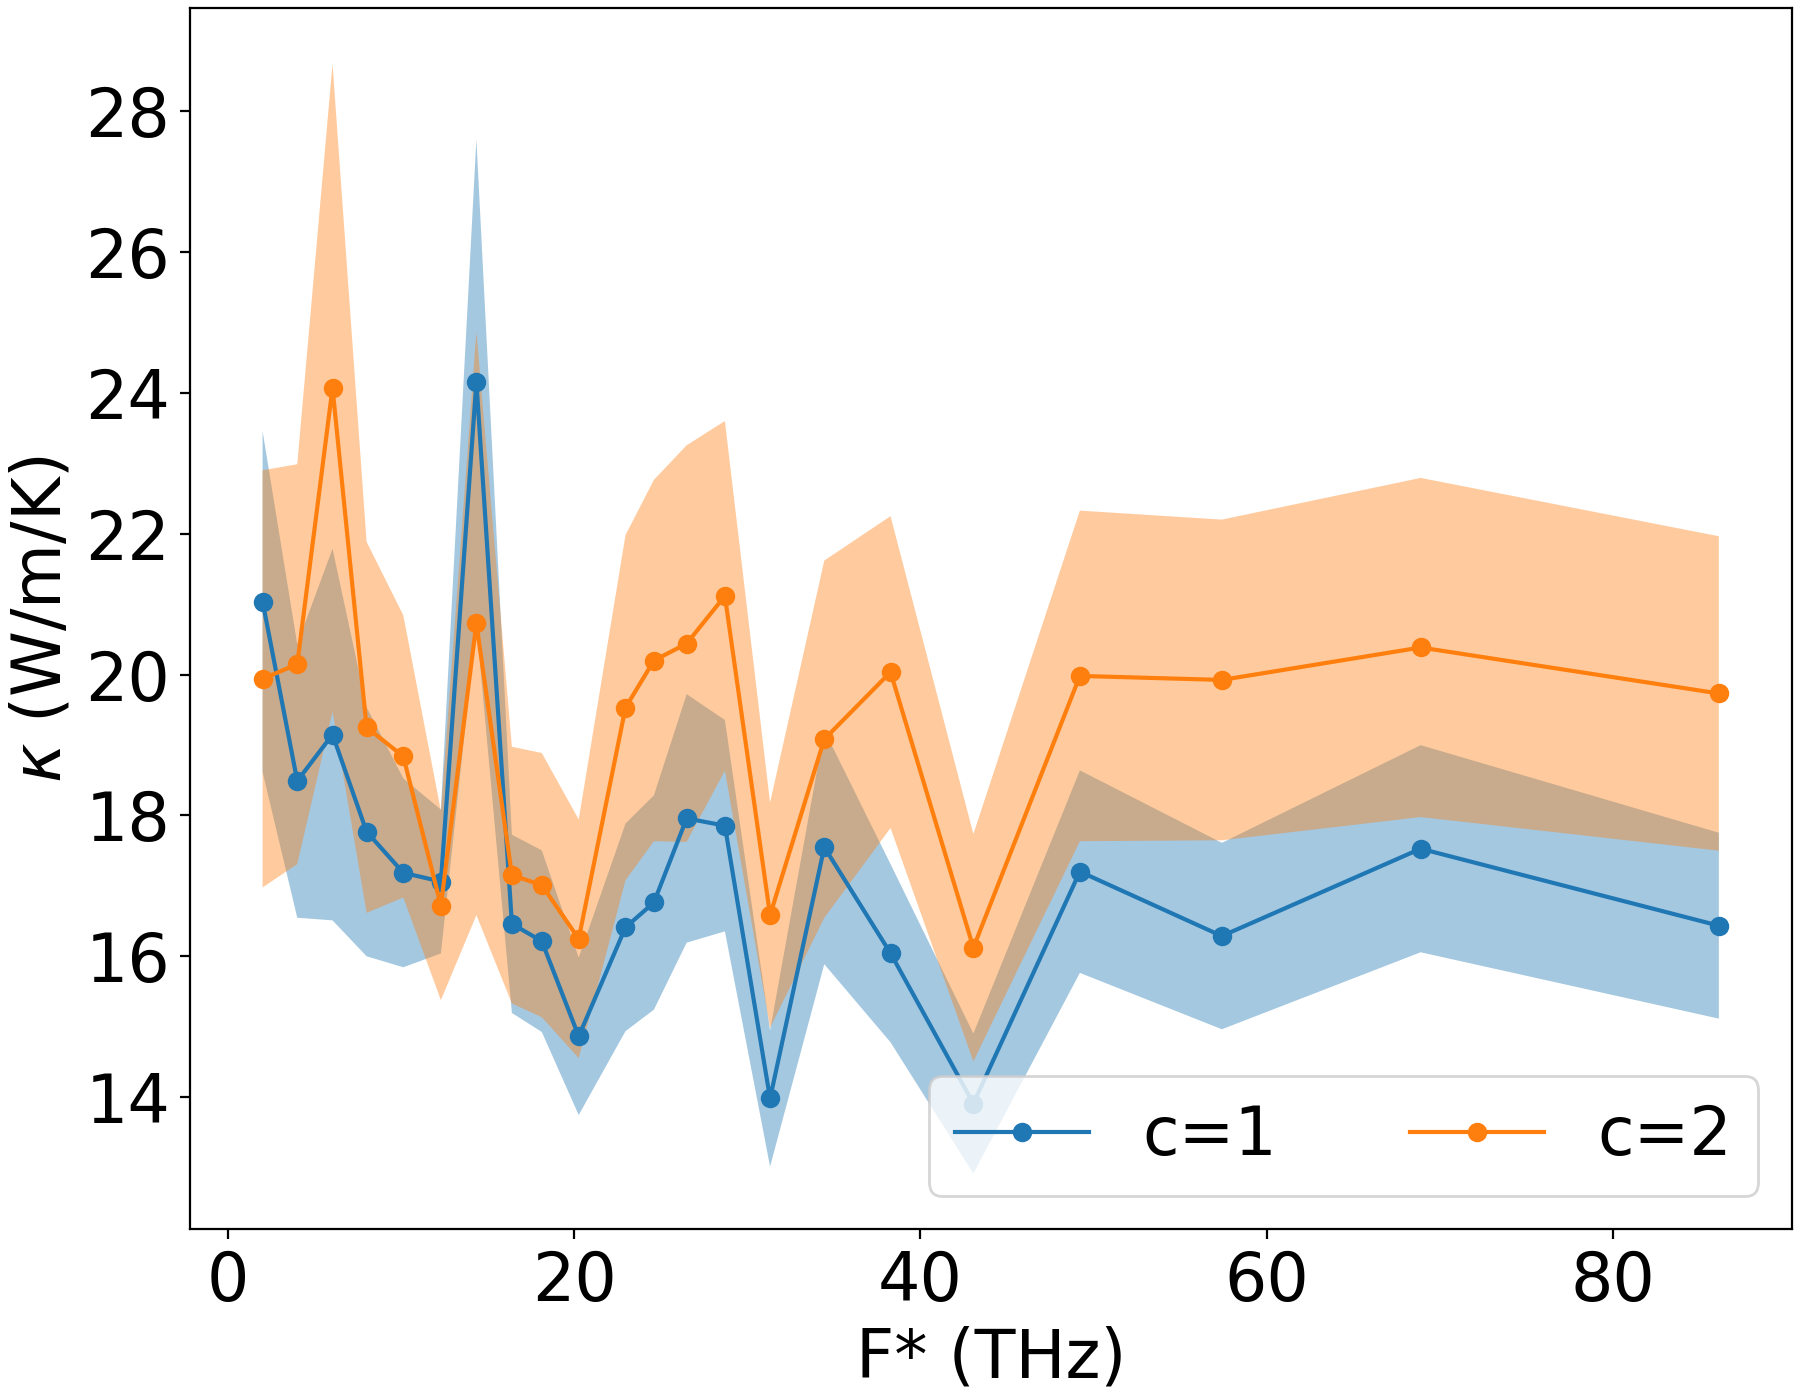

In [51]:
%matplotlib notebook
FSTAR_LIST = jenIcex.Nyquist_f_THz/TSKIP_LIST
plot_k_fSTAR(jjjenIcex,FSTAR_LIST)

In [52]:
tr_ps = np.array([75.,73.]+[i for i in range(70,9,-5)])
tr_ps = np.array([len(jeniceX)*dt_fsIceX*1e-3*(i+1)/20 for i in range(20)])
print(tr_ps)
#fstar = 13.8 è quella riportata nel paper
jenTime,jenTimef,kappasICE = kappa_time(tr_ps=tr_ps,current_list=[jeniceX],dt_fs=dt_fsIceX,Tmean=TmeanIceX,llvol=llvolIceX,units='qepw',Kmin_corrfactor=1,fstar_THz=13.8)
#jenTime2,jenTimef2,kappasICE2 = kappa_time(tr_ps=tr_ps,current_list=[jeniceX],abdt_fs=abdt_fs,Tmeanab=Tmeanab,llvol=llvol,units='qepw',Kmin_corrfactor=2,fstar_THz=13.8)

[ 3.65214612  7.30429224 10.95643836 14.60858448 18.2607306  21.91287672
 25.56502284 29.21716896 32.86931508 36.5214612  40.17360732 43.82575344
 47.47789956 51.13004568 54.7821918  58.43433792 62.08648404 65.73863016
 69.39077628 73.0429224 ]
end_step [ 2516.  5033.  7549. 10066. 12582. 15099. 17615. 20132. 22648. 25165.
 27681. 30198. 32714. 35231. 37747. 40264. 42780. 45297. 47813. 50330.] [ 3.65142048  7.30429224 10.95571272 14.60858448 18.26000496 21.91287672
 25.5642972  29.21716896 32.86858944 36.5214612  40.17288168 43.82575344
 47.47717392 51.13004568 54.78146616 58.43433792 62.0857584  65.73863016
 69.39005064 73.0429224 ]
0 2516.0
Using single component code.
Using single component code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     344.52346 THz
 Resampling freq          f* =      13.78094 THz
 Sampling time         TSKIP =            25 steps
           

Using single component code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     344.52346 THz
 Resampling freq          f* =      13.78094 THz
 Sampling time         TSKIP =            25 steps
                             =        36.282 fs
 Original  n. of frequencies =         17616
 Resampled n. of frequencies =           705
 PSD      @cutoff  (pre-filter&sample) ~      0.00179
                  (post-filter&sample) ~      0.00413
 log(PSD) @cutoff  (pre-filter&sample) ~     -6.74426
                  (post-filter&sample) ~     -5.56385
 min(PSD)          (pre-filter&sample) =      0.00000
 min(PSD)         (post-filter&sample) =      0.00004
 % of original PSD Power f<f* (pre-filter&sample)  =  0.513 %
-----------------------------------------------------

-----------------------------------------------------
  CEPSTRAL ANALYSIS
--------------------------------------

<IPython.core.display.Javascript object>


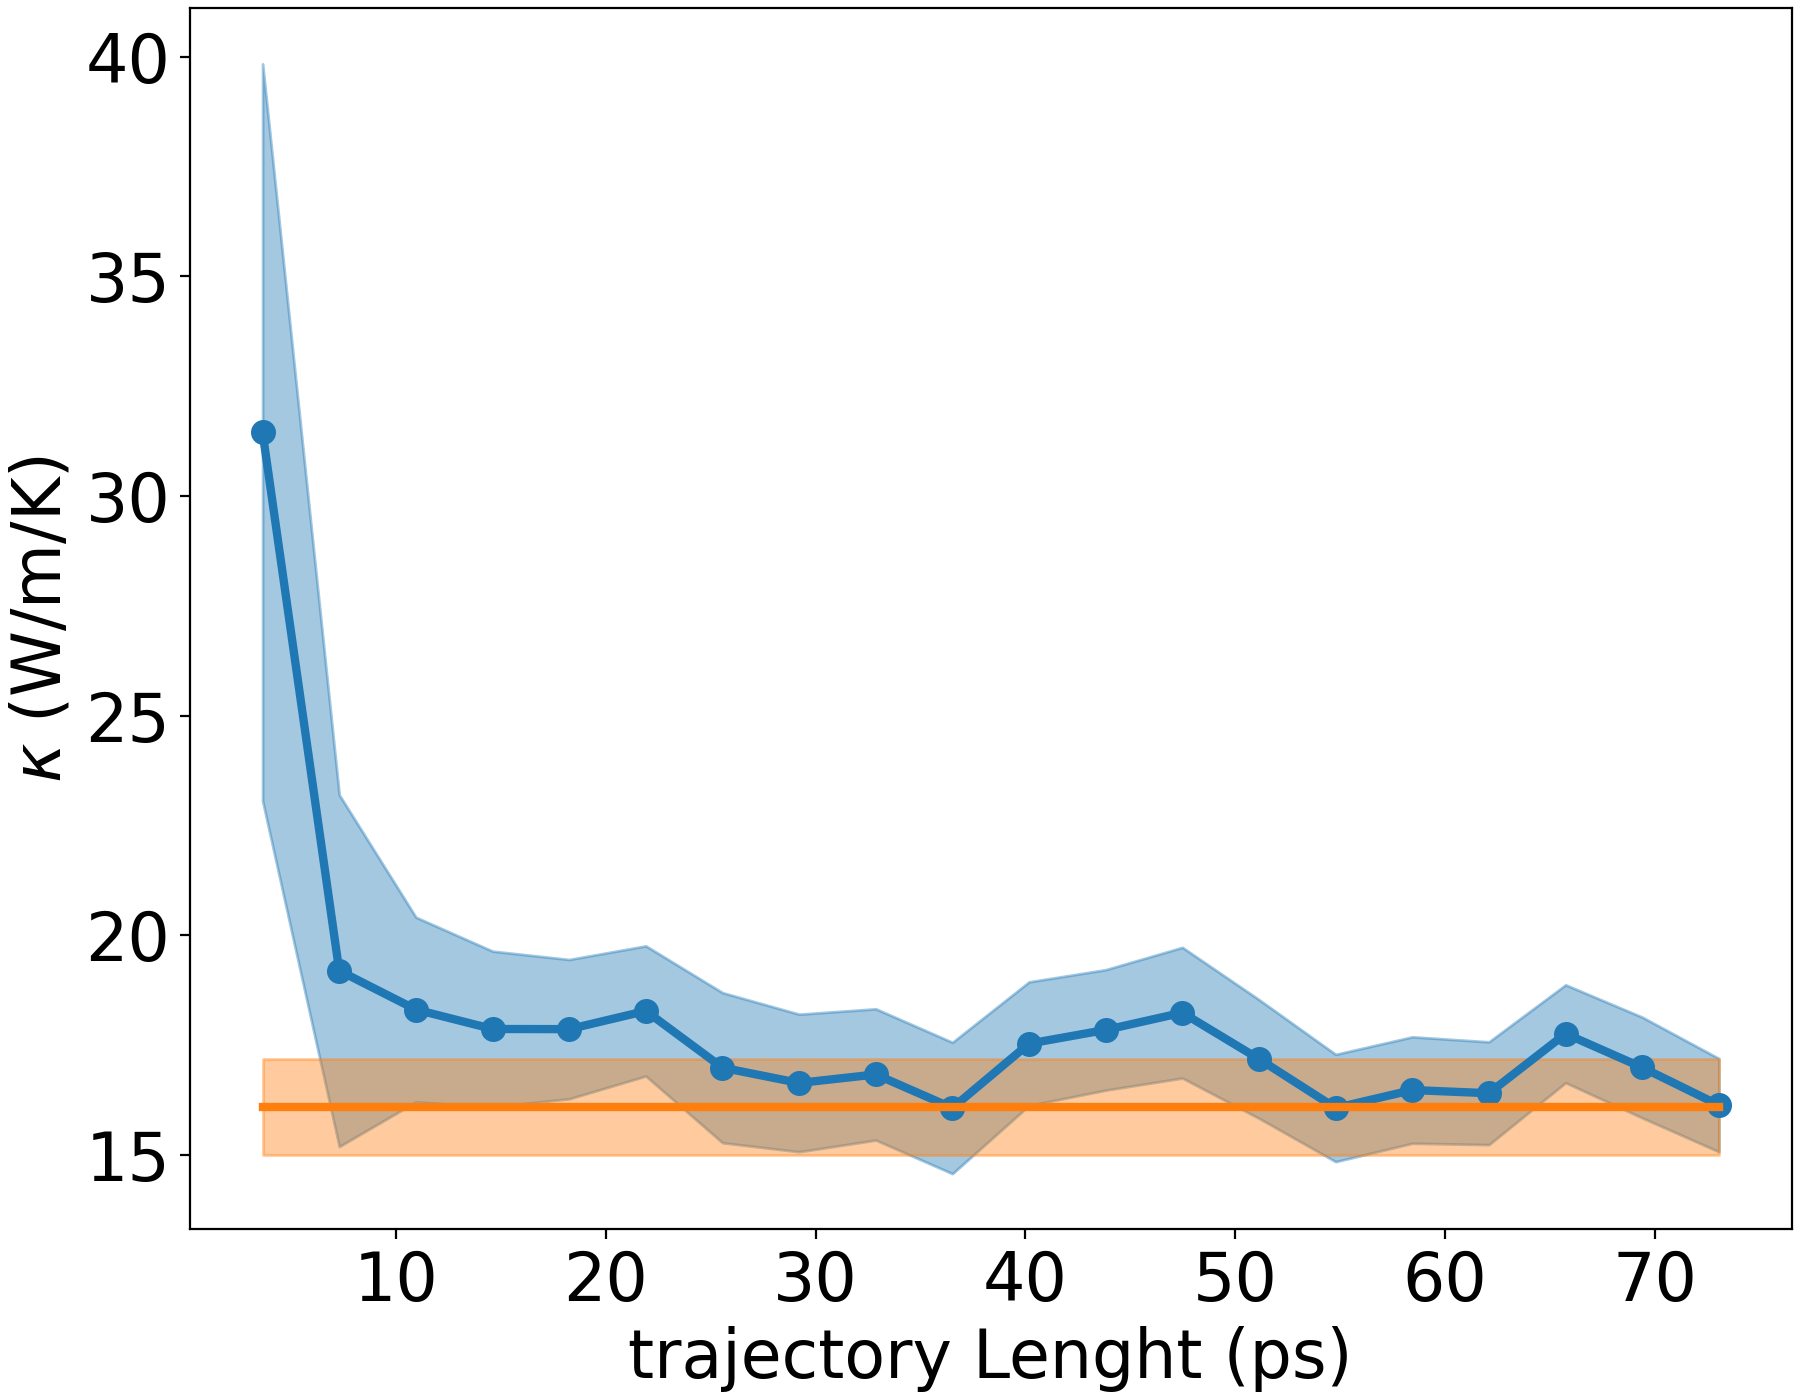

Text(0, 0.5, '$\\kappa$ (W/m/K)')

In [53]:
%matplotlib notebook


fix,ax = plt.subplots(1, figsize=(9.0,7.0), constrained_layout=True)
ls=24
# 

ax.tick_params(axis='x', labelsize=ls)
ax.tick_params(axis='y', labelsize=ls)
llen =len(kappasICE[:,0]) 
FEDEVAL = np.array([16.1]*llen)
FEDESTD = np.array([1.1]*llen)
#f1=ax.plot(FSTAR_LIST, kappa_Kmin[cor],'-o',label='c={}'.format(cor))
#ax.errorbar(kappas[:,0],kappas[:,1],kappas[:,2],ls='-',marker='o',lw=3,ms=8)
f=ax.plot(kappasICE[:,0],kappasICE[:,1],ls='-',marker='o',lw=3,ms=8)
ax.fill_between(kappasICE[:,0],kappasICE[:,1]+kappasICE[:,2],kappasICE[:,1]-kappasICE[:,2],color=f[0].get_color(),alpha=0.4)
#f=ax.plot(kappasICE2[:,0],kappasICE2[:,1],ls='-',marker='o',lw=3,ms=8)
#ax.fill_between(kappasICE2[:,0],kappasICE2[:,1]+kappasICE2[:,2],kappasICE2[:,1]-kappasICE2[:,2],color=f[0].get_color(),alpha=0.4)



f=ax.plot(kappasICE[:,0],FEDEVAL,ls='-',lw=3)
ax.fill_between(kappasICE[:,0],FEDEVAL+FEDESTD,FEDEVAL-FEDESTD,color=f[0].get_color(),alpha=0.4)


ax.set_xlabel('trajectory Lenght (ps)',fontsize=ls)
ax.set_ylabel(r'$\kappa$ (W/m/K)',fontsize=ls)
#ax.legend(loc='lower right',fontsize=ls,ncol=3)
#plt.savefig('kappa_corr_Fstar_1.pdf',dpp=300)

# Figure 3 of the main text

<IPython.core.display.Javascript object>


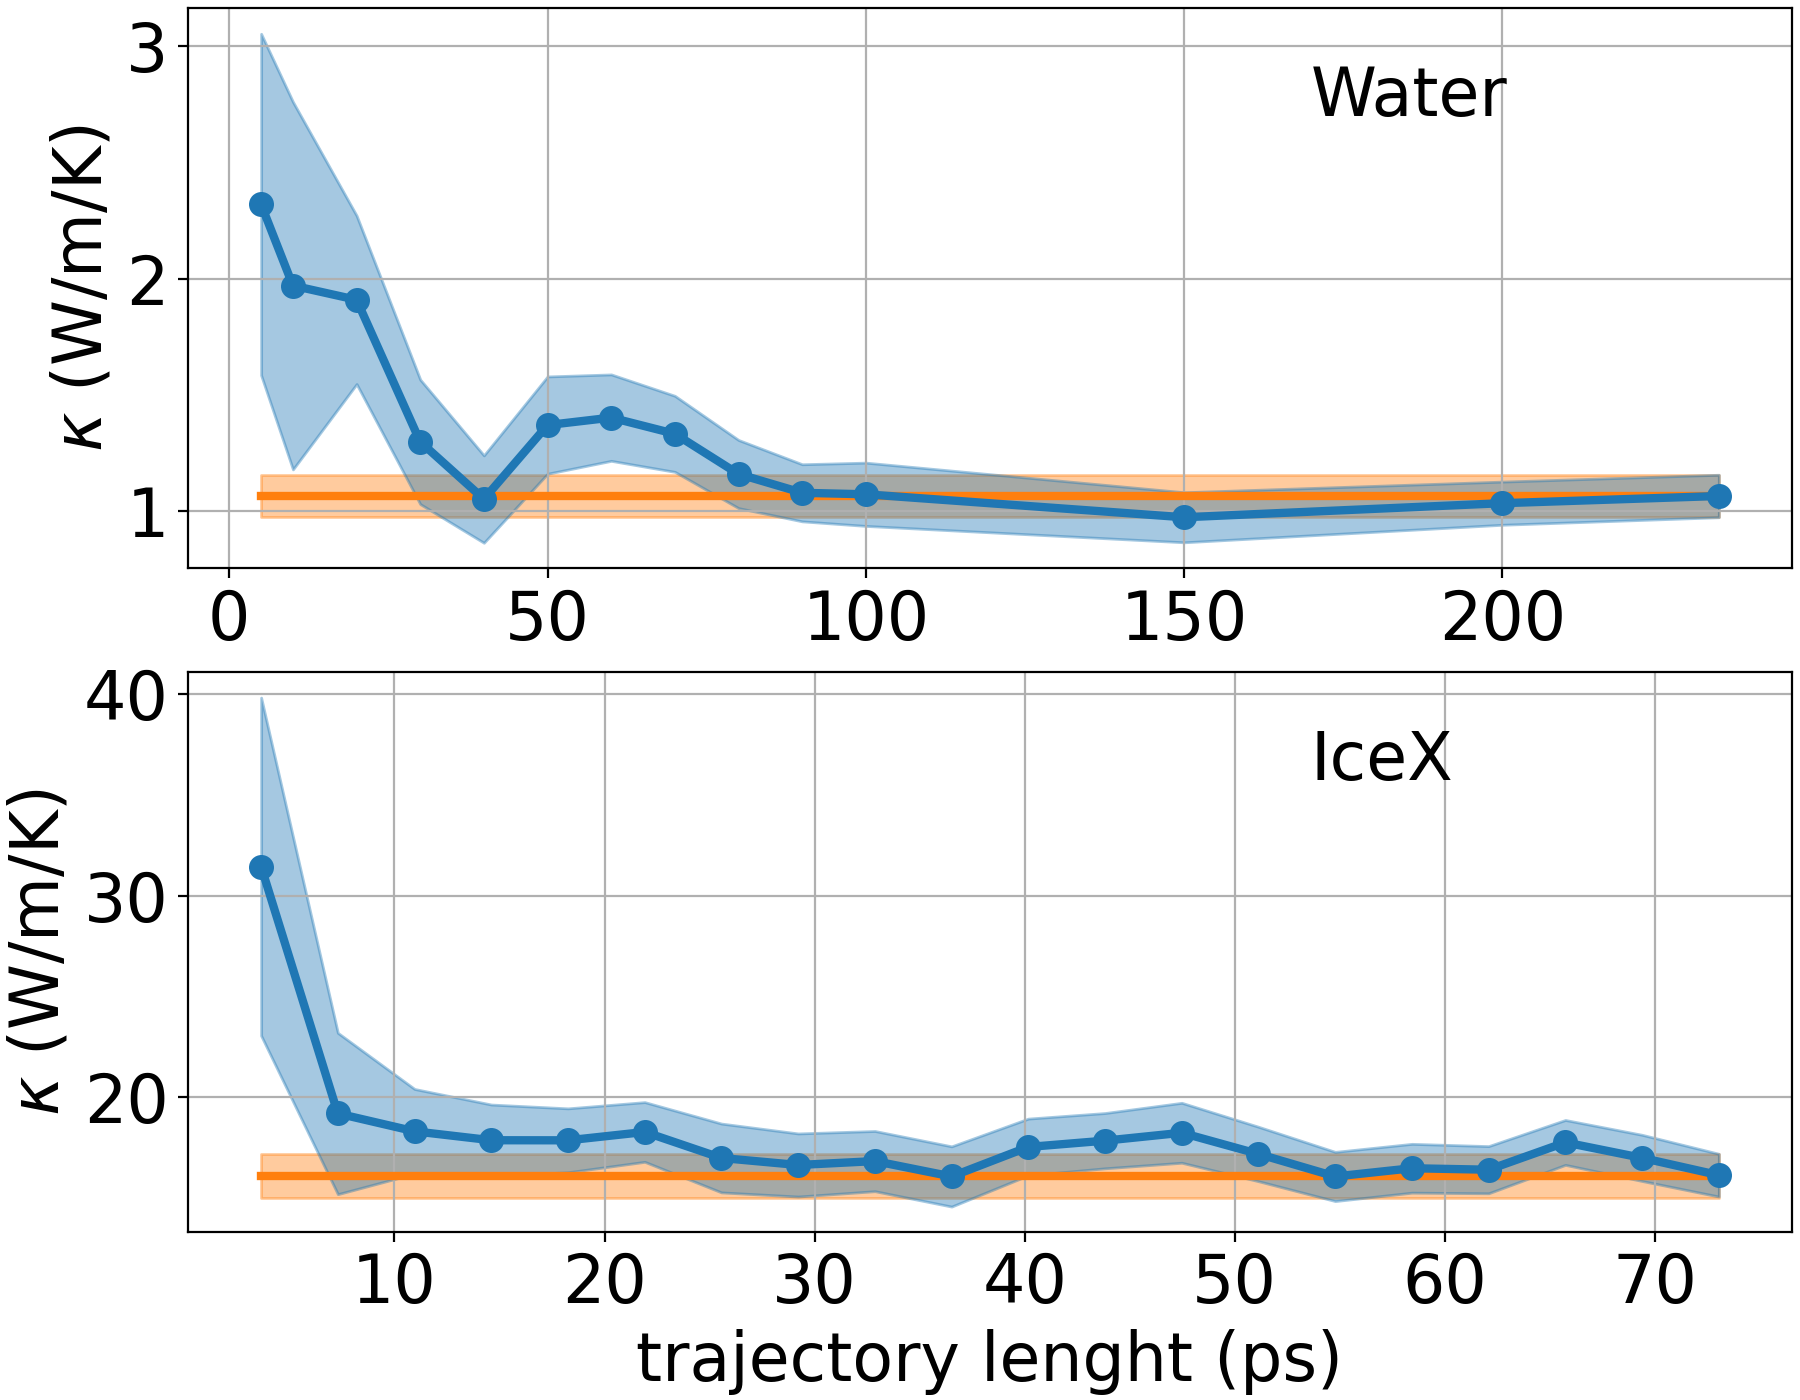

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


<ipython-input-54-60a7b8592a24>:53: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpp" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('Water_IceX_vs_ps.pdf',dpp=300)


In [54]:
%matplotlib notebook


fix,axs = plt.subplots(2,1, figsize=(9.0,7.0), constrained_layout=True)
ls=24
# 
ax=axs[0]

ax.tick_params(axis='x', labelsize=ls)
ax.tick_params(axis='y', labelsize=ls)
axs[1].tick_params(axis='x', labelsize=ls)
axs[1].tick_params(axis='y', labelsize=ls)
llen =len(kappasICE[:,0]) 
FEDEVAL = np.array([16.1]*llen)
FEDESTD = np.array([1.1]*llen)

llen =len(kappas_30THz[:,0]) 
VAL = np.array([kappas_30THz[0,1]]*llen)
STD = np.array([kappas_30THz[0,2]]*llen)
#f1=ax.plot(FSTAR_LIST, kappa_Kmin[cor],'-o',label='c={}'.format(cor))
#ax.errorbar(kappas[:,0],kappas[:,1],kappas[:,2],ls='-',marker='o',lw=3,ms=8)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
print(colors)

f=axs[1].plot(kappasICE[:,0],FEDEVAL,ls='-',lw=3,color=colors[1])
axs[1].fill_between(kappasICE[:,0],FEDEVAL+FEDESTD,FEDEVAL-FEDESTD,color=f[0].get_color(),alpha=0.4)
f=ax.plot(kappas_30THz[:,0],VAL,ls='-',lw=3,color=colors[1])
ax.fill_between(kappas_30THz[:,0],VAL+STD,VAL-STD,color=f[0].get_color(),alpha=0.4)





f=axs[1].plot(kappasICE[:,0],kappasICE[:,1],ls='-',marker='o',lw=3,ms=8,label='iceX')
axs[1].fill_between(kappasICE[:,0],kappasICE[:,1]+kappasICE[:,2],kappasICE[:,1]-kappasICE[:,2],color=f[0].get_color(),alpha=0.4)
f=ax.plot(kappas_30THz[:,0],kappas_30THz[:,1],ls='-',marker='o',lw=3,ms=8,label='water')
ax.fill_between(kappas_30THz[:,0],kappas_30THz[:,1]+kappas_30THz[:,2],kappas_30THz[:,1]-kappas_30THz[:,2],color=f[0].get_color(),alpha=0.4)


ax.text(0.7, 0.9, 'Water', fontsize=ls,transform=ax.transAxes,
        verticalalignment='top')

axs[1].text(0.7, 0.9, 'IceX', fontsize=ls,transform=axs[1].transAxes,
        verticalalignment='top')
ax.grid()
axs[1].grid()

axs[1].set_xlabel('trajectory lenght (ps)',fontsize=ls)
ax.set_ylabel(r'$\kappa$ (W/m/K)',fontsize=ls)
axs[1].set_ylabel(r'$\kappa$ (W/m/K)',fontsize=ls)
#ax.legend(loc='lower right',fontsize=ls,ncol=3)
plt.savefig('Water_IceX_vs_ps.pdf',dpp=300)

# Econv=$10^{-8}$Ry

In [8]:
thermo =  np.loadtxt('water64.evp')
current = np.loadtxt('current_hz_econv_10-8.dat')

In [9]:
Tmean = np.mean(thermo[57000:,4])
Tstd = np.std(thermo[57000:,4])
print('T = {} +/- {}'.format(Tmean,Tstd))

T = 619.3274119611847 +/- 27.675117714880074


In [10]:
#SET PARAMETERS
jenab = current[::2,2:5]
vcmO =current[::2,8:11]
jelab = current[::2,5:8]
llvol=12946.1031 *(0.529177249**3) # vol in Amstrong^3
dt_fs = (current[2,1] - current[0,1] )*1e3
print('T = {} \nVol = {} \ndt_fs = {}'.format(Tmean,llvol,dt_fs))


T = 619.3274119611847 
Vol = 1918.4149668990613 
dt_fs = 1.3999999999967372


Using multicomponent code.


<ipython-input-5-44e145d3f49f>:33: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  TSKIP_LIST = np.array(TSKIP_LIST,dtype=np.int)


[178  89  59  44  35  29  25  22  19  17  16  14  13  12  11  10   9   8
   7   6   5   4]
TSKIP =  178 - FSTAR =  2.00642 THz
Using multicomponent code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 3  (P* = 4, corr_factor = 1.000000)
  L_0*   =         -14.025197 +/-   0.156355
  S_0*   =           0.000003 +/-   0.000000
-----------------------------------------------------
  kappa* =           0.808198 +/-   0.126366  W/mK
-----------------------------------------------------

TSKIP =   89 - FSTAR =  4.01284 THz
Using multicomponent code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 5  (P* = 6, corr_factor = 1.000000)
  L_0*   =         -14.146750 +/-   0.138594
  S_0*   =           0.000003 +/-   0.000000
-----------------------------------------------------
  kappa* =           0.715695 +/-

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 25  (P* = 26, corr_factor = 1.000000)
  L_0*   =         -13.797959 +/-   0.083685
  S_0*   =           0.000004 +/-   0.000000
-----------------------------------------------------
  kappa* =           1.014392 +/-   0.084890  W/mK
-----------------------------------------------------

TSKIP =    6 - FSTAR =  59.5238 THz
Using multicomponent code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 36  (P* = 37, corr_factor = 1.000000)
  L_0*   =         -13.874358 +/-   0.092692
  S_0*   =           0.000003 +/-   0.000000
-----------------------------------------------------
  kappa* =           0.939780 +/-   0.087111  W/mK
-----------------------------------------------------

TSKIP =    5 - FSTAR =  71.4286 THz
Using multicomponent code.
--------------

<ipython-input-5-44e145d3f49f>:33: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  TSKIP_LIST = np.array(TSKIP_LIST,dtype=np.int)


Using multicomponent code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 6  (P* = 7, corr_factor = 2.000000)
  L_0*   =         -14.002047 +/-   0.213076
  S_0*   =           0.000003 +/-   0.000001
-----------------------------------------------------
  kappa* =           0.827126 +/-   0.176241  W/mK
-----------------------------------------------------

TSKIP =   89 - FSTAR =  4.01284 THz
Using multicomponent code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 10  (P* = 11, corr_factor = 2.000000)
  L_0*   =         -14.222976 +/-   0.191495
  S_0*   =           0.000002 +/-   0.000000
-----------------------------------------------------
  kappa* =           0.663168 +/-   0.126994  W/mK
-----------------------------------------------------

TSKIP =   59 - FSTAR =  6.05327 THz
Using multicompo

Using multicomponent code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 50  (P* = 51, corr_factor = 2.000000)
  L_0*   =         -13.990838 +/-   0.117767
  S_0*   =           0.000003 +/-   0.000000
-----------------------------------------------------
  kappa* =           0.836449 +/-   0.098506  W/mK
-----------------------------------------------------

TSKIP =    6 - FSTAR =  59.5238 THz
Using multicomponent code.
-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 72  (P* = 73, corr_factor = 2.000000)
  L_0*   =         -13.980920 +/-   0.130637
  S_0*   =           0.000003 +/-   0.000000
-----------------------------------------------------
  kappa* =           0.844787 +/-   0.110361  W/mK
-----------------------------------------------------

TSKIP =    5 - FSTAR =  71.4286 THz
Using multicom

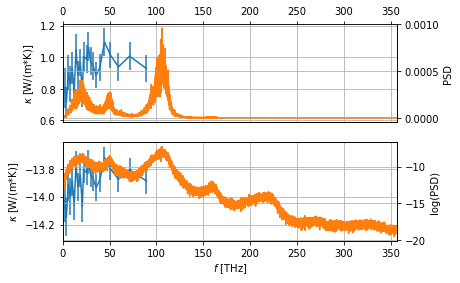

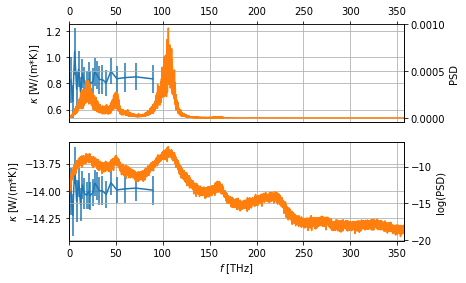

In [11]:
# Create HeatCurrent
jen, jjjen,TSKIP_LIST = k_compute(current_list=[jenab,jelab,vcmO],dt_fs=dt_fs,Tmean=Tmean,llvol=llvol,units='qepw')

In [12]:
#Filter the spectrum with F* = 20 THz
jf=jen.resample(fstar_THz=20,plot=False,PSD_FILTER_W=0.1)

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     357.14286 THz
 Resampling freq          f* =      19.84127 THz
 Sampling time         TSKIP =            18 steps
                             =        25.200 fs
 Original  n. of frequencies =         83859
 Resampled n. of frequencies =          4659
 PSD      @cutoff  (pre-filter&sample) ~      0.00029
                  (post-filter&sample) ~      0.00021
 log(PSD) @cutoff  (pre-filter&sample) ~     -8.76117
                  (post-filter&sample) ~     -9.38386
 min(PSD)          (pre-filter&sample) =      0.00000
 min(PSD)         (post-filter&sample) =      0.00000
 % of original PSD Power f<f* (pre-filter&sample)  = 13.814 %
-----------------------------------------------------



In [13]:
# COMPUTE kappa
jen.cepstral_analysis(Kmin_corrfactor=1)
jf.cepstral_analysis(Kmin_corrfactor=1)

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 118  (P* = 119, corr_factor = 1.000000)
  L_0*   =         -13.542976 +/-   0.068183
  S_0*   =           0.000005 +/-   0.000000
-----------------------------------------------------
  kappa* =           1.309012 +/-   0.089252  W/mK
-----------------------------------------------------

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 10  (P* = 11, corr_factor = 1.000000)
  L_0*   =         -13.824947 +/-   0.086116
  S_0*   =           0.000004 +/-   0.000000
-----------------------------------------------------
  kappa* =           0.987382 +/-   0.085029  W/mK
-----------------------------------------------------



<IPython.core.display.Javascript object>


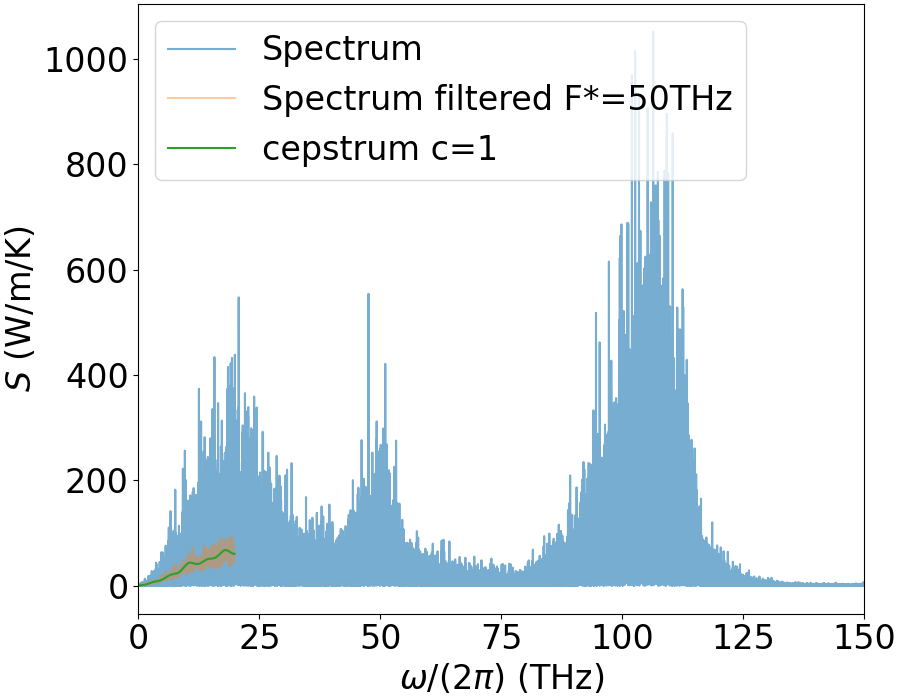

In [14]:
%matplotlib notebook
# plot the spectrum
fix,ax = plt.subplots(1, figsize=(9.0,7.0), constrained_layout=True)
ls=24
# 
ax.tick_params(axis='x', labelsize=ls)
ax.tick_params(axis='y', labelsize=ls)

j=jen
j1=jf



conv=j.KAPPA_SCALE/2

ax.set_xlim((0.,150))

alpha=0.6
gg=ax.plot(j.freqs_THz, j.psd*conv, label=r'Spectrum',alpha=alpha)

ff=ax.plot(j1.freqs_THz, j1.fpsd*conv, label=r'Spectrum filtered F*=50THz',alpha=0.4)
ff=ax.plot(j1.freqs_THz, j1.dct.psd*conv, label=r'cepstrum c=1')

ax.set_xlabel(r'$\omega/(2\pi)$ (THz)',fontsize=ls)
ax.set_ylabel(r'$S$ (W/m/K)',fontsize=ls)
ax.legend(loc='upper left',fontsize=ls)
#plt.savefig('Spettro_12.pdf',dpp=300)

<IPython.core.display.Javascript object>


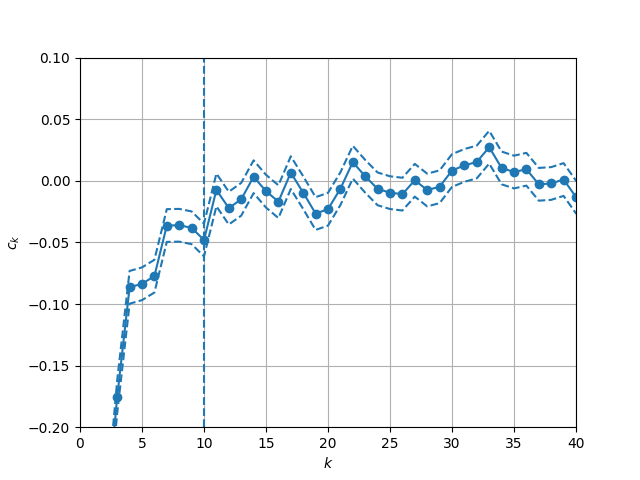

In [15]:
# plot the cepstral C_k vs k
# you can see that for k=20 the C_k are almost zero
ax=jf.plot_ck()
ax.set_ylim(-0.2,0.1)
ax.set_xlim(0,40)
ax.grid()

<IPython.core.display.Javascript object>


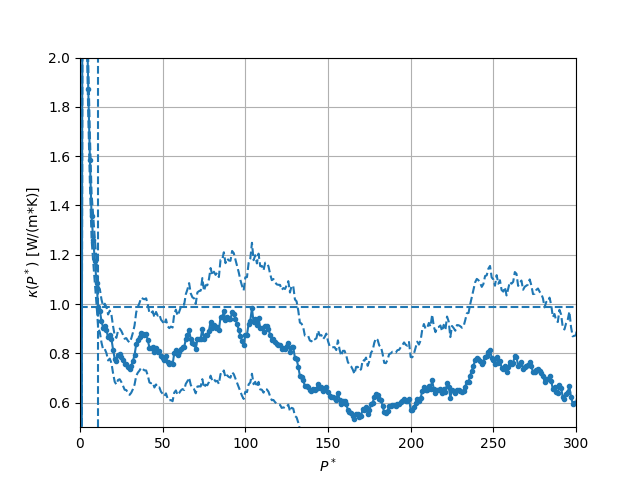

In [16]:
# plot kappa vs P*
# kappa do not change increasing P*
ax=jf.plot_kappa_Pstar()
ax.set_ylim(0.5,2)
ax.set_xlim(0,300)
ax.grid()

# $\kappa$ vs Fstar


## The picture below show that F*=30 is a fine coiche

<IPython.core.display.Javascript object>


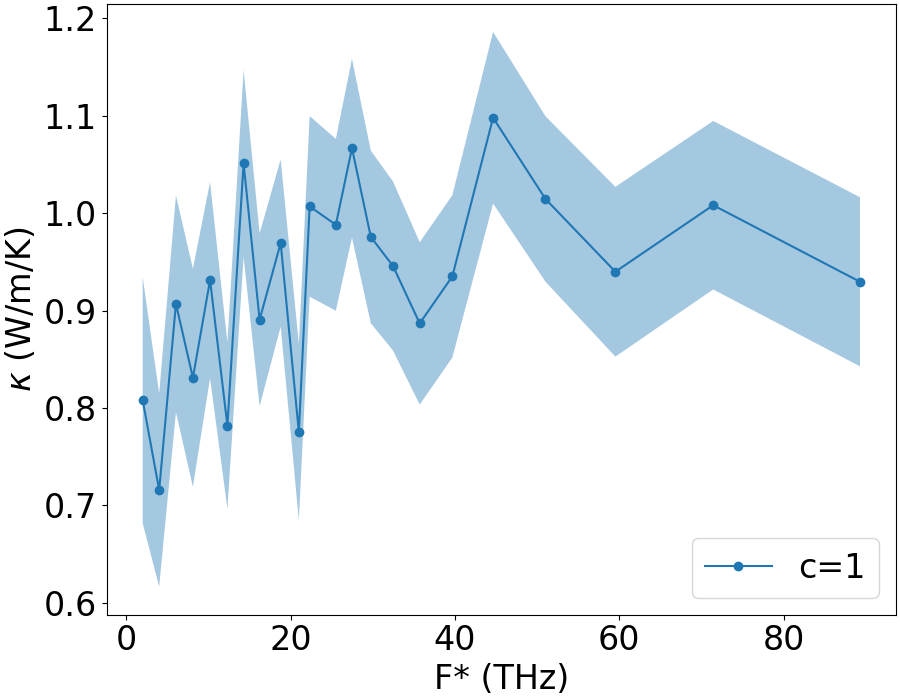

In [28]:
%matplotlib notebook


fix,ax = plt.subplots(1, figsize=(9.0,7.0), constrained_layout=True)
ls=24
# 

ax.tick_params(axis='x', labelsize=ls)
ax.tick_params(axis='y', labelsize=ls)
kappa_Kmin={}
kappa_Kmin_err={}
FSTAR_LIST = jen.Nyquist_f_THz/TSKIP_LIST
#for cor in corrfactors:
for cor in [1]:
    kappa_Kmin[cor] = np.array([j.kappa_Kmin for j in jjjen[cor]])
    kappa_Kmin_err[cor] = np.array([j.kappa_Kmin_std for j in jjjen[cor]])
    f1=ax.plot(FSTAR_LIST, kappa_Kmin[cor],'-o',label='c={}'.format(cor))
    ax.fill_between(FSTAR_LIST, kappa_Kmin[cor]-kappa_Kmin_err[cor],kappa_Kmin[cor]+kappa_Kmin_err[cor],alpha=0.4)
    #f1=ax.errorbar( FSTAR_LIST, kappa_Kmin, yerr=kappa_Kmin_err, capsize=4,label='c={}'.format(cor))
    #ax.axhline(np.mean(kappa_Kmin),ls='--',c=f1[0].get_color())
#ax.plot( FSTAR_LIST, kappa_Kmin, c='r')
#ax.semilogx()
#f1=ax.plot(FSTAR_LIST, FEDE,'-',label='abinitio'.format(cor))
#ax.fill_between(FSTAR_LIST, FEDE-FEDEerr,FEDE+FEDEerr,alpha=0.4)
#ax.set_xlim([5,150])
ax.set_xlabel('F* (THz)',fontsize=ls)
ax.set_ylabel(r'$\kappa$ (W/m/K)',fontsize=ls)
ax.legend(loc='lower right',fontsize=ls,ncol=3)
#plt.savefig('kappa_corr_Fstar_1.pdf',dpp=300)

In [29]:
ltraj = current[-1,0] - current[0,0]
dstep = current[1,0] - current[0,0]
print(ltraj/(dstep)*dt_fs*1e-3,ltraj,dstep)

469.60199999890557 3354300.0 10.0


In [30]:
tr_ps = np.array([235., 234.,200.,150.,100.,90.,80.,70.,60.,50.,40.,30.,20.,10.,5.])

print(tr_ps)
current_list=[jenab,jelab,vcmO]
#fstar = 13.8 è quella riportata nel paper
#kappa_time(tr_ps,current_list,abdt_fs,Tmeanab,llvol,units='qepw',fstar_THz=30.,Kmin_corrfactor=1)
jenTime_20THz ,jenTimef_20THz ,kappas_20THz = kappa_time(tr_ps=tr_ps,current_list=current_list,dt_fs=dt_fs,Tmean=Tmean,llvol=llvol,units='qepw',Kmin_corrfactor=1.,fstar_THz=20.)
jenTime_30THz ,jenTimef_30THz ,kappas_30THz = kappa_time(tr_ps=tr_ps,current_list=current_list,dt_fs=dt_fs,Tmean=Tmean,llvol=llvol,units='qepw',Kmin_corrfactor=1.,fstar_THz=30.)
jenTime_40THz ,jenTimef_40THz ,kappas_40THz = kappa_time(tr_ps=tr_ps,current_list=current_list,dt_fs=dt_fs,Tmean=Tmean,llvol=llvol,units='qepw',Kmin_corrfactor=1.,fstar_THz=40.)

[235. 234. 200. 150. 100.  90.  80.  70.  60.  50.  40.  30.  20.  10.
   5.]
end_step [167857. 167142. 142857. 107142.  71428.  64285.  57142.  50000.  42857.
  35714.  28571.  21428.  14285.   7142.   3571.] [234.9998 233.9988 199.9998 149.9988  99.9992  89.999   79.9988  70.
  59.9998  49.9996  39.9994  29.9992  19.999    9.9988   4.9994]
0 167857.0
Using multicomponent code.
Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     357.14286 THz
 Resampling freq          f* =      19.84127 THz
 Sampling time         TSKIP =            18 steps
                             =        25.200 fs
 Original  n. of frequencies =         83859
 Resampled n. of frequencies =          4659
 PSD      @cutoff  (pre-filter&sample) ~      0.00029
                  (post-filter&sample) ~      0.00021
 log(PSD) @cutoff  (pre-filter&sample) ~     -8.76117
           

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     357.14286 THz
 Resampling freq          f* =      19.84127 THz
 Sampling time         TSKIP =            18 steps
                             =        25.200 fs
 Original  n. of frequencies =         28572
 Resampled n. of frequencies =          1588
 PSD      @cutoff  (pre-filter&sample) ~      0.00031
                  (post-filter&sample) ~      0.00044
 log(PSD) @cutoff  (pre-filter&sample) ~     -8.31673
                  (post-filter&sample) ~     -8.20810
 min(PSD)          (pre-filter&sample) =      0.00000
 min(PSD)         (post-filter&sample) =      0.00000
 % of original PSD Power f<f* (pre-filter&sample)  = 14.175 %
-----------------------------------------------------

-----------------------------------------------------
  CEPSTRAL ANALYSIS
----------------------------------------

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     357.14286 THz
 Resampling freq          f* =      29.76190 THz
 Sampling time         TSKIP =            12 steps
                             =        16.800 fs
 Original  n. of frequencies =         83859
 Resampled n. of frequencies =          6989
 PSD      @cutoff  (pre-filter&sample) ~      0.00011
                  (post-filter&sample) ~      0.00010
 log(PSD) @cutoff  (pre-filter&sample) ~     -9.82823
                  (post-filter&sample) ~     -9.81603
 min(PSD)          (pre-filter&sample) =      0.00000
 min(PSD)         (post-filter&sample) =      0.00000
 % of original PSD Power f<f* (pre-filter&sample)  = 24.867 %
-----------------------------------------------------

-----------------------------------------------------
  CEPSTRAL ANALYSIS
----------------------------------------

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     357.14286 THz
 Resampling freq          f* =      29.76190 THz
 Sampling time         TSKIP =            12 steps
                             =        16.800 fs
 Original  n. of frequencies =         28572
 Resampled n. of frequencies =          2381
 PSD      @cutoff  (pre-filter&sample) ~      0.00011
                  (post-filter&sample) ~      0.00016
 log(PSD) @cutoff  (pre-filter&sample) ~     -9.47858
                  (post-filter&sample) ~     -9.22097
 min(PSD)          (pre-filter&sample) =      0.00000
 min(PSD)         (post-filter&sample) =      0.00000
 % of original PSD Power f<f* (pre-filter&sample)  = 25.119 %
-----------------------------------------------------

-----------------------------------------------------
  CEPSTRAL ANALYSIS
----------------------------------------

end_step [167857. 167142. 142857. 107142.  71428.  64285.  57142.  50000.  42857.
  35714.  28571.  21428.  14285.   7142.   3571.] [234.9998 233.9988 199.9998 149.9988  99.9992  89.999   79.9988  70.
  59.9998  49.9996  39.9994  29.9992  19.999    9.9988   4.9994]
0 167857.0
Using multicomponent code.
Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     357.14286 THz
 Resampling freq          f* =      39.68254 THz
 Sampling time         TSKIP =             9 steps
                             =        12.600 fs
 Original  n. of frequencies =         83859
 Resampled n. of frequencies =          9318
 PSD      @cutoff  (pre-filter&sample) ~      0.00009
                  (post-filter&sample) ~      0.00008
 log(PSD) @cutoff  (pre-filter&sample) ~     -9.90152
                  (post-filter&sample) ~     -9.87120
 min(PSD)          (pre-filter&samp

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     357.14286 THz
 Resampling freq          f* =      39.68254 THz
 Sampling time         TSKIP =             9 steps
                             =        12.600 fs
 Original  n. of frequencies =         28572
 Resampled n. of frequencies =          3175
 PSD      @cutoff  (pre-filter&sample) ~      0.00007
                  (post-filter&sample) ~      0.00014
 log(PSD) @cutoff  (pre-filter&sample) ~     -9.92692
                  (post-filter&sample) ~     -9.17473
 min(PSD)          (pre-filter&sample) =      0.00000
 min(PSD)         (post-filter&sample) =      0.00000
 % of original PSD Power f<f* (pre-filter&sample)  = 30.523 %
-----------------------------------------------------

-----------------------------------------------------
  CEPSTRAL ANALYSIS
----------------------------------------

<IPython.core.display.Javascript object>


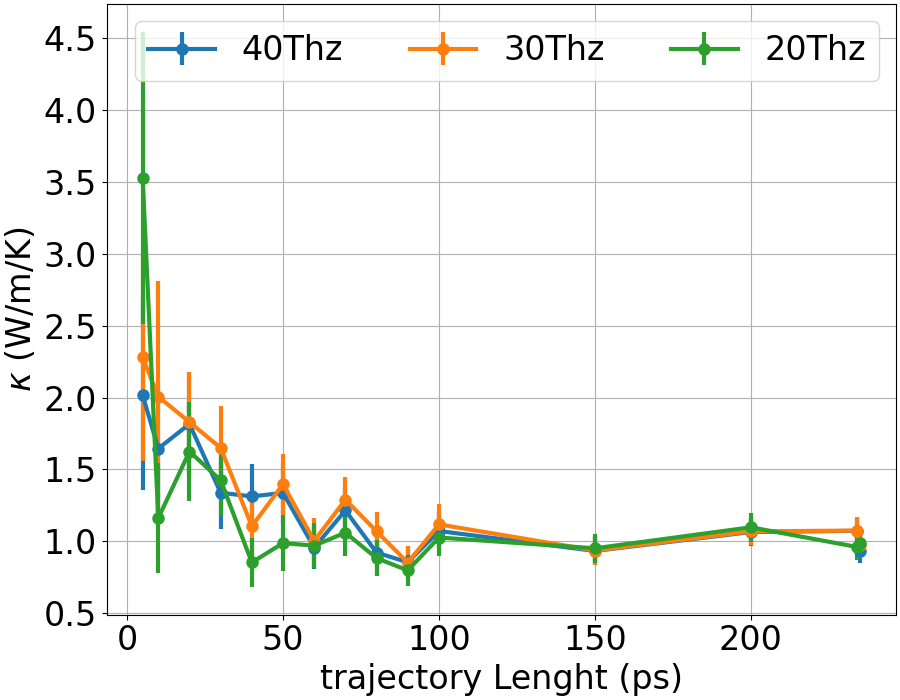

In [31]:
%matplotlib notebook


fix,ax = plt.subplots(1, figsize=(9.0,7.0), constrained_layout=True)
ls=24
# 

ax.tick_params(axis='x', labelsize=ls)
ax.tick_params(axis='y', labelsize=ls)

#f1=ax.plot(FSTAR_LIST, kappa_Kmin[cor],'-o',label='c={}'.format(cor))
ax.errorbar(kappas_40THz[:,0],kappas_40THz[:,1],kappas_40THz[:,2],ls='-',marker='o',lw=3,ms=8,label='40Thz')
ax.errorbar(kappas_30THz[:,0],kappas_30THz[:,1],kappas_30THz[:,2],ls='-',marker='o',lw=3,ms=8,label='30Thz')
ax.errorbar(kappas_20THz[:,0],kappas_20THz[:,1],kappas_20THz[:,2],ls='-',marker='o',lw=3,ms=8,label='20Thz')

ax.grid()



ax.set_xlabel('trajectory Lenght (ps)',fontsize=ls)
ax.set_ylabel(r'$\kappa$ (W/m/K)',fontsize=ls)
ax.legend(loc='upper right',fontsize=ls,ncol=3)


In [32]:
kappas_30THz[0,1],kappas_30THz[0,2]

(0.9755404180468367, 0.08854766005185959)